### Predict total bikes that will be rented per day
#### This notebook uses the *bike_day_v2.xlsx*

### Dataset description

- **instant**: record index
- **dteday** : date
- **season** : season (1:spring, 2:summer, 3:fall, 4:winter)
- **yr** : year (0: 2011, 1:2012)
- **mnth** : month (1 to 12)
- **holiday** : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- **weekday** : day of the week
- **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0
- **schoolday** : if day is a normal school day is 1, otherwise is 0
- **weathersit** :
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** : Normalized temperature in Celsius. The values are divided to 41 (max)
- **atemp**: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- **hum**: Normalized humidity. The values are divided to 100 (max)
- **windspeed**: Normalized wind speed. The values are divided to 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

### Work description

#### Overview
<p>The customer whishes to build a model to predict everyday at 15h00 the total number of bikes they will rent the following day. This will allow them not only to better allocate staff resources, but also to define their daily marketing budget in social media which is their principal form of advertisement.</p>

#### Model building

<p>To achieve the objective, it is followed a systematic approach, CRISP-DM, that involves several stages. It is started by preparing the data, cleaning, and organizing it for analysis. Next, perform exploratory data analysis (EDA) to gain insights into the dataset and identify any patterns or trends. Once we have a thorough understanding of the data, it is proceed to train and evaluate predictive models using 4 different machine learning techniques with their best parameters such as: <p>

- Random Forest Regressor
- XGBoost 
- GradientBoosting 
- Lasso Regression

I tried to explore various models from different families, including bagging techniques like RandomForestRegressor, boosting methods such as XGBoost and GradientBoosting, as well as Lasso Regression.

### Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import re
import math
import calendar
import graphviz
import warnings
from tabulate import tabulate
import time
import optuna
import pickle

# Machine Learning Libraries
from sklearn import tree
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, max_error, make_scorer
from yellowbrick.model_selection import RFECV, LearningCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
import xgboost as xgb

# Set random state and cross-validation folds
random_state = 2024
n_splits = 10
cv = 10

# Warnings handling
warnings.filterwarnings("ignore")

# Set seaborn style
sns.set_style("whitegrid")

### Helper functions:

#### Function to visualize distributions of numerical columns

In [2]:
def plot_distribution(ds, numerical_cols):
    """
    Plot distribution of numerical columns in the dataset.

    Parameters:
        ds (DataFrame): The dataset.
        numerical_cols (list): List of numerical column names to plot.

    Returns:
        None

    Example:
        plot_distribution(ds, numerical_cols)
    """
    num_cols = len(numerical_cols)
    num_rows = math.ceil(num_cols / 2)  # Calculate the number of rows needed

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(11, 5*num_rows))

    for i, col in enumerate(numerical_cols):
        row = i // 2  # Calculate the row index for the subplot
        col_index = i % 2  # Calculate the column index for the subplot

        # Plot histogram with kernel density estimate
        sns.histplot(ds[col], kde=True, ax=axes[row, col_index])

        # Calculate skewness and kurtosis
        skewness = round(ds[col].skew(), 2)
        kurtosis = round(ds[col].kurt(), 2)

        # Set title for subplot
        axes[row, col_index].set_title(f"Distribution of {col}\n Skewness: {skewness}, Kurtosis: {kurtosis}", fontsize=10)

    # Hide empty subplots if the number of columns is odd
    if num_cols % 2 != 0:
        axes[-1, -1].axis('off')

    # Adjust layout and display plot
    plt.tight_layout()
    plt.show()

#### Function to visualize the learning curve of a machine learning model using 10-fold-cross-validation

In [3]:
def plot_learning_curve(X, y, estimator, train_sizes=np.linspace(0.1, 1.0, 5), scoring='r2', n_jobs=4, random_state=random_state):
    """
    Plot learning curve to visualize the effect of training size on model performance.

    Parameters:
        X (array-like): The input samples.
        y (array-like): The target values.
        estimator: The machine learning model to evaluate.
        train_sizes (array-like, optional): The training sizes to use for plotting the learning curve.
            Default is np.linspace(0.1, 1.0, 5).
        scoring (str, callable, list, tuple, or dict, optional): The scoring strategy to evaluate the model.
            Default is 'r2' for coefficient of determination.
        n_jobs (int, optional): Number of jobs to run in parallel for computation. Default is 4.
        random_state (int or None, optional): Random state for reproducibility. Default is 2024.
    """
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

    visualizer = LearningCurve(
        estimator=estimator,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=n_jobs,
        random_state=random_state
    )

    visualizer.fit(X, y)
    visualizer.show()

#### Function to evaluate the performance of the models on both training and testing datasets

In [4]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a machine learning model using various metrics.

    Parameters:
        model: The trained machine learning model.
        X_train (array-like): The feature matrix of the training set.
        y_train (array-like): The target values of the training set.
        X_test (array-like): The feature matrix of the test set.
        y_test (array-like): The target values of the test set.

    Returns:
        None

    Metrics used:
        - Execution Time
        - MAE (Mean Absolute Error)
        - RMSE (Root Mean Squared Error)
        - R^2 (R-squared)
        - Adjusted R^2
        - MAPE (Mean Absolute Percentage Error)
        - Max Error

    Example:
        evaluate_model(model, X_train, y_train, X_test, y_test)
    """
    start_time = time.time()

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    end_time = time.time()
    execution_time = end_time - start_time

    n_train_samples, n_train_features = X_train.shape
    n_test_samples, n_test_features = X_test.shape

    # Calculate evaluation metrics for train set
    train_mae = mean_absolute_error(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_r_squared = r2_score(y_train, train_pred)
    train_adjusted_r_squared = 1 - (1 - train_r_squared) * (n_train_samples - 1) / (n_train_samples - n_train_features - 1)
    train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
    train_max_err = max_error(y_train, train_pred)

    # Calculate evaluation metrics for test set
    test_mae = mean_absolute_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r_squared = r2_score(y_test, test_pred)
    test_adjusted_r_squared = 1 - (1 - test_r_squared) * (n_test_samples - 1) / (n_test_samples - n_test_features - 1)
    test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
    test_max_err = max_error(y_test, test_pred)

    # Print the results directly
    headers = ["Metric", "Train Score", "Test Score"]
    print(tabulate([
        ["Execution Time (s)", execution_time, execution_time],
        ["MAE", train_mae, test_mae],
        ["RMSE", train_rmse, test_rmse],
        ["R^2", train_r_squared, test_r_squared],
        ["Adjusted R^2", train_adjusted_r_squared, test_adjusted_r_squared],
        ["MAPE", train_mape, test_mape],
        ["Max Error", train_max_err, test_max_err]
    ], headers=headers, floatfmt=".4f", tablefmt="grid"))

#### Function to visualize residuals

In [5]:
def visualize_residuals(model, X_train, y_train, X_test, y_test):
    """
    Visualize the residuals of a machine learning model.

    Parameters:
        model: The trained machine learning model.
        X_train (array-like): The feature matrix of the training set.
        y_train (array-like): The target values of the training set.
        X_test (array-like): The feature matrix of the test set.
        y_test (array-like): The target values of the test set.

    Returns:
        None

    Example:
        visualize_residuals(model, X_train, y_train, X_test, y_test)
    """
    # Initialize ResidualsPlot object
    residuals_vis = ResidualsPlot(model)

    # Fit the training data to the visualizer
    residuals_vis.fit(X_train, y_train)

    # Evaluate the model on the test data
    residuals_vis.score(X_test, y_test)

    # Display the plot
    residuals_vis.show()

#### Function to visualize prediction error

In [6]:
def visualize_prediction_error(model, X_train, y_train, X_test, y_test):
    """
    Visualize the prediction errors of a machine learning model.

    Parameters:
        model: The trained machine learning model.
        X_train (array-like): The feature matrix of the training set.
        y_train (array-like): The target values of the training set.
        X_test (array-like): The feature matrix of the test set.
        y_test (array-like): The target values of the test set.

    Returns:
        None

    Example:
        visualize_prediction_error(model, X_train, y_train, X_test, y_test)
    """
    # Initialize PredictionError object
    predError_vis = PredictionError(model)

    # Fit the training data to the visualizer
    predError_vis.fit(X_train, y_train)

    # Evaluate the model on the test data
    predError_vis.score(X_test, y_test)

    # Display the plot
    predError_vis.show()

### Loading the data

In [7]:
# Load the excel file
ds = pd.read_excel('bike_day_v2.xlsx', engine='openpyxl')

In [8]:
# View top 5 rows
ds.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,schoolday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6.0,0,0.0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0.0,0,0.0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1.0,1,1.0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2.0,1,1.0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3.0,1,1.0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [9]:
# Check number of entries and data types for columns
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     732 non-null    int64         
 1   dteday      732 non-null    datetime64[ns]
 2   season      732 non-null    int64         
 3   yr          732 non-null    int64         
 4   mnth        732 non-null    int64         
 5   holiday     732 non-null    int64         
 6   weekday     730 non-null    float64       
 7   workingday  732 non-null    int64         
 8   schoolday   454 non-null    float64       
 9   weathersit  732 non-null    int64         
 10  temp        732 non-null    float64       
 11  atemp       732 non-null    float64       
 12  hum         732 non-null    float64       
 13  windspeed   732 non-null    float64       
 14  casual      732 non-null    int64         
 15  registered  732 non-null    int64         
 16  cnt         732 non-null  

- The dataset has 732 rows, 16 features and 1 target(cnt) column.
- Column names does not seem interpretable. It will be renamed and replaced with corresponding names.
- Since the 'instant' column is an index, it will be dropped.
- There are missing values in 'weekday' and 'schoolday' columns. The importance, reason and percentage of missing values will be discussed for the future actions.
- Data type of the columns look reasonable.
- 'dteday' column will be dropped because the dataset has year(yr), month(mnth) and the weekday column. Also it is not preferable and interpretable to use raw date column in modeling.
- The 'feeling_temperature' column is likely to be highly correlated with the 'temperature' column. Similarly, there might be a high correlation between the 'holiday' and 'workingday' columns.
- Since we are interested in predicting total rental counts (cnt) and not differentiating between casual and registered users, and also 'total_rental' column is the sum of the 'casual' and 'registered' users, I will exclude 'casual' and 'registered' columns.

It will be evaluated whether the statistics align with our initial observations and then decide whether to drop them accordingly.

### Rename the columns

In [10]:
ds.rename(columns={'dteday': 'date',
                   'yr': 'year',
                   'mnth': 'month',
                   'weathersit': 'weather_condition',
                   'temp': 'temperature',
                   'atemp': 'feeling_temperature',
                   'hum': 'humidity',
                   'cnt': 'total_rental'}, inplace=True)
print(ds.columns)

Index(['instant', 'date', 'season', 'year', 'month', 'holiday', 'weekday',
       'workingday', 'schoolday', 'weather_condition', 'temperature',
       'feeling_temperature', 'humidity', 'windspeed', 'casual', 'registered',
       'total_rental'],
      dtype='object')


### Replace numerical values with corresponding names

In [11]:
ds.season.replace({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"}, inplace=True)

ds.year.replace({0: 2011, 1:2012},inplace=True)

ds.month.replace({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
                  5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                  9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}, inplace=True)

ds.holiday.replace({0: 'no', 1: 'yes' }, inplace=True)

ds.weekday.replace({0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}, inplace=True)

ds.workingday.replace({0: 'no', 1: 'yes' }, inplace=True)

ds.schoolday.replace({0: 'no', 1: 'yes' }, inplace=True)

ds.weather_condition.replace({1: 'Clear & Few clouds', 2: 'Mist & Cloudy' , 3: 'Light snow & Rain', 4: 'Heavy Rain & Snow'}, inplace=True)

print(ds.season.unique())
print(ds.year.unique())
print(ds.month.unique())
print(ds.holiday.unique())
print(ds.weekday.unique())
print(ds.workingday.unique())
print(ds.schoolday.unique())
print(ds.weather_condition.unique())

['Spring' 'Summer' 'Fall' 'Winter']
[2011 2012]
['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec']
['no' 'yes']
['Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday'
 nan]
['no' 'yes']
['no' 'yes' nan]
['Mist & Cloudy' 'Clear & Few clouds' 'Light snow & Rain']


Name of the columns and values are renamed and replaced correctly. We move on!  

### Extract the day from 'date' column

In [12]:
# Extract the day and create a new column
ds['day'] = ds['date'].dt.day

# Replacing the index for 'day' column
ds.insert(5, 'day', ds.pop('day'))

Day in the 'date' is extracted to see where it is a good feature.

In [13]:
# Quick view for renamed values and 'day' column
ds.head()

,instant,date,season,year,month,day,holiday,weekday,workingday,schoolday,weather_condition,temperature,feeling_temperature,humidity,windspeed,casual,registered,total_rental
0,1,2011-01-01,Spring,2011,Jan,1,no,Saturday,no,no,Mist & Cloudy,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,Spring,2011,Jan,2,no,Sunday,no,no,Mist & Cloudy,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,Spring,2011,Jan,3,no,Monday,yes,yes,Clear & Few clouds,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,Spring,2011,Jan,4,no,Tuesday,yes,yes,Clear & Few clouds,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,Spring,2011,Jan,5,no,Wednesday,yes,yes,Clear & Few clouds,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### Reformat the data types

In [14]:
# Convert categorical columns to categorical data type
categorical_cols = ['season', 'year', 'month', 'holiday', 'weekday', 'workingday', 'schoolday', 'weather_condition']
for col in categorical_cols:
    ds[col] = ds[col].astype('category')

print(ds.dtypes)

instant                         int64
date                   datetime64[ns]
season                       category
year                         category
month                        category
day                             int32
holiday                      category
weekday                      category
workingday                   category
schoolday                    category
weather_condition            category
temperature                   float64
feeling_temperature           float64
humidity                      float64
windspeed                     float64
casual                          int64
registered                      int64
total_rental                    int64
dtype: object


Columns are converted into correct dtypes successfully.

## DATA UNDERSTANDING

### Summary statistics

In [15]:
ds.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
instant,732.0,NaN,NaN,NaN,366.352459,1.0,183.75,366.5,549.25,731.0,211.236679
date,732,NaN,NaN,NaN,2012-01-01 08:27:32.459016448,2011-01-01 00:00:00,2011-07-02 18:00:00,2012-01-01 12:00:00,2012-07-02 06:00:00,2012-12-31 00:00:00,NaN
season,732,4,Fall,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,732.0,2.0,2012.0,367.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,732,12,Aug,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,732.0,NaN,NaN,NaN,15.737705,1.0,8.0,16.0,23.0,31.0,8.803963
holiday,732,2,no,711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,730,7,Saturday,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,732,2,yes,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
schoolday,454,2,no,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Key observations:

- Fall is the most common season in the dataset.
- Saturdays are the most frequent weekday recorded.
- "Clear & Few clouds" is the dominant weather condition.
- Average daily casual rentals are approximately 851, while registered rentals average around 3659.
- Total daily rental counts average about 4510 with min. 22 and max. 8714 rentals. 
- Holidays appears infrequently (around 2.87% of days), with the majority being working days.

### Duplicate check

In [16]:
duplicate_rows = ds[ds.duplicated(keep=False)]
print("Duplicate rows:")
duplicate_rows

Duplicate rows:


,instant,date,season,year,month,day,holiday,weekday,workingday,schoolday,weather_condition,temperature,feeling_temperature,humidity,windspeed,casual,registered,total_rental
623,624,2012-09-15,Fall,2012,Sep,15,no,Saturday,no,no,Clear & Few clouds,0.608333,0.585867,0.501667,0.247521,3160,5554,8714
624,624,2012-09-15,Fall,2012,Sep,15,no,Saturday,no,no,Clear & Few clouds,0.608333,0.585867,0.501667,0.247521,3160,5554,8714


One duplicate row is detected. It will be dropped.

### Unique values for each column

In [17]:
col = ds.columns

for cols in col:
    unique_values = ds[cols].unique()
    print(f"Unique values in {cols}: {unique_values}") # Click text editor(VScode) to check all unique values

Unique values in instant: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 

There is no meaningless or junk value, we are good.

### Missing values

In [18]:
count = ds.isnull().sum().sort_values(ascending=False)
percentage = ((ds.isnull().sum()/len(ds)*100)).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1,
keys = ['Count', 'Percentage'])

print('Count and percantage of missing values for the columns:')

missing_data

Count and percantage of missing values for the columns:


,Count,Percentage
schoolday,278,37.978142
weekday,2,0.273224
weather_condition,0,0.000000
registered,0,0.000000
casual,0,0.000000
windspeed,0,0.000000
humidity,0,0.000000
feeling_temperature,0,0.000000
temperature,0,0.000000
instant,0,0.000000


- With **''schoolday'**' column almost 38% missing values, imputing them can introduce bias. So, we may consider dropping this column if it doesn't provide significant information for the model.

- Since the percentage of missing values of the **'weekday'**' column is relatively low (0.27%), we will impute these missing values.

### Distribution of numerical values

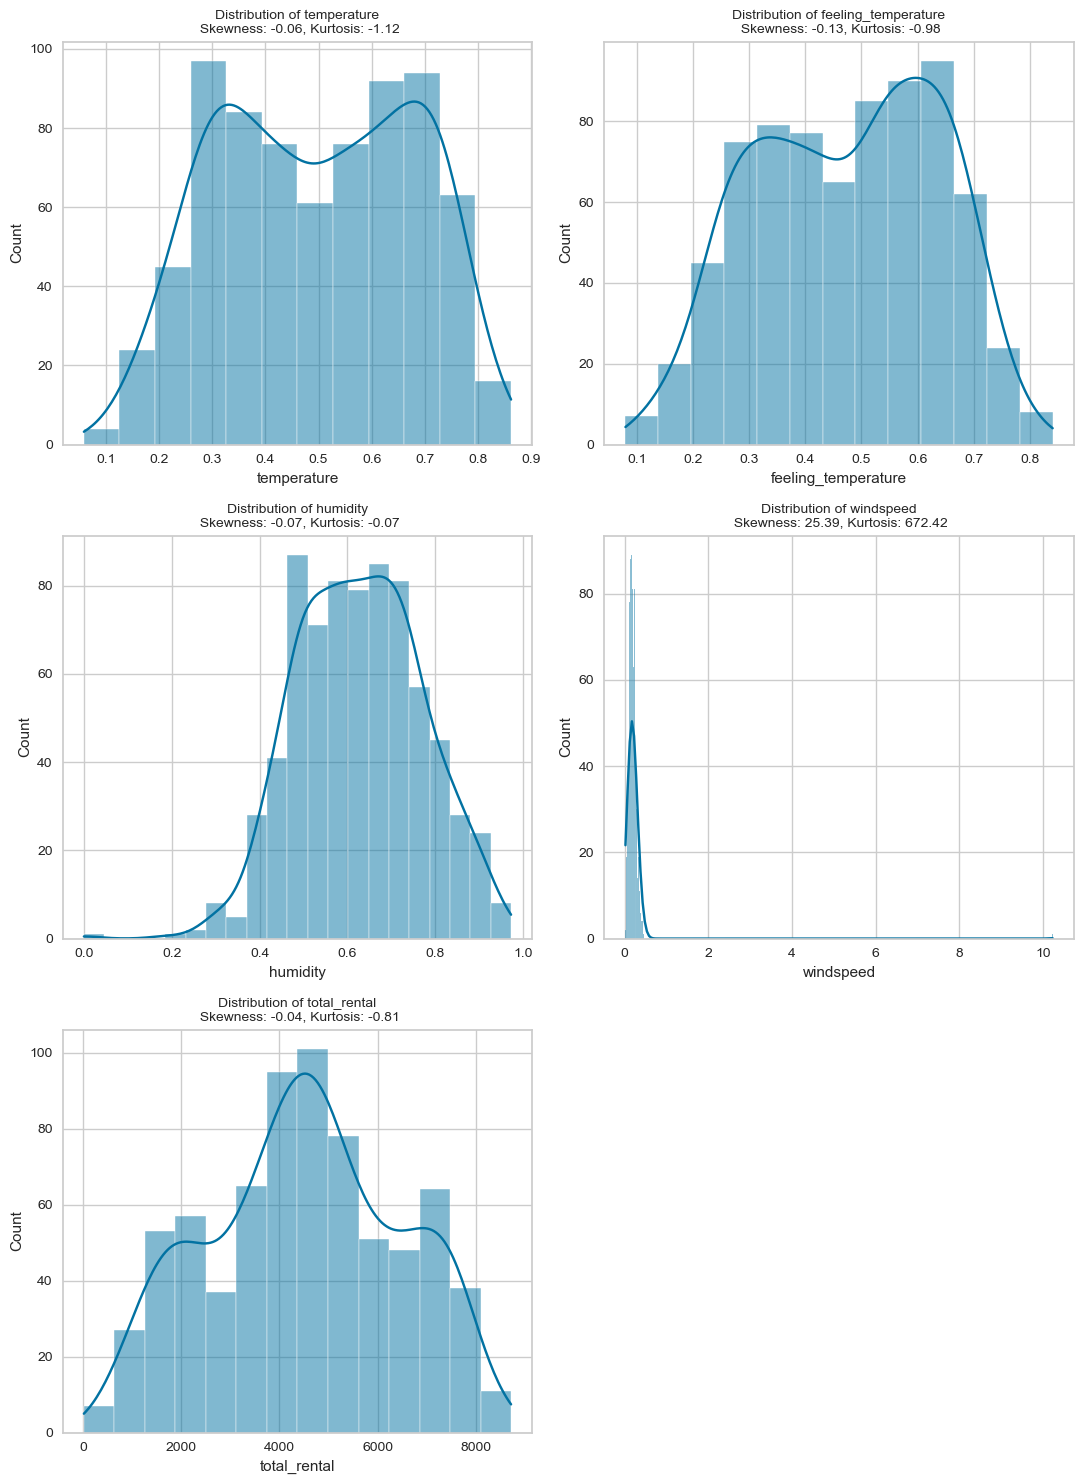

In [19]:
numerical_cols = ['temperature',
                  'feeling_temperature',
                  'humidity',
                  'windspeed',
                  #'casual',
                  #'registered',
                  'total_rental']
plot_distribution(ds, numerical_cols)

- 'temperature' and 'feeling_tempretaure' is close to normal distribution.
- 'humidity' column is left skewed, it has small outliers.
- 'windspeed' has small but extreme outliers.

### Outliers detection


Since some of the columns of the dataset is not normally distributed, percentiles will be calculated to check outliers.

Outliers in humidity: [0.187917 0.      ]
Outliers in windspeed: [ 0.417908  0.507463 10.234234  0.388067  0.422275  0.415429  0.409212
  0.421642  0.441563  0.4148    0.386821  0.398008  0.407346]


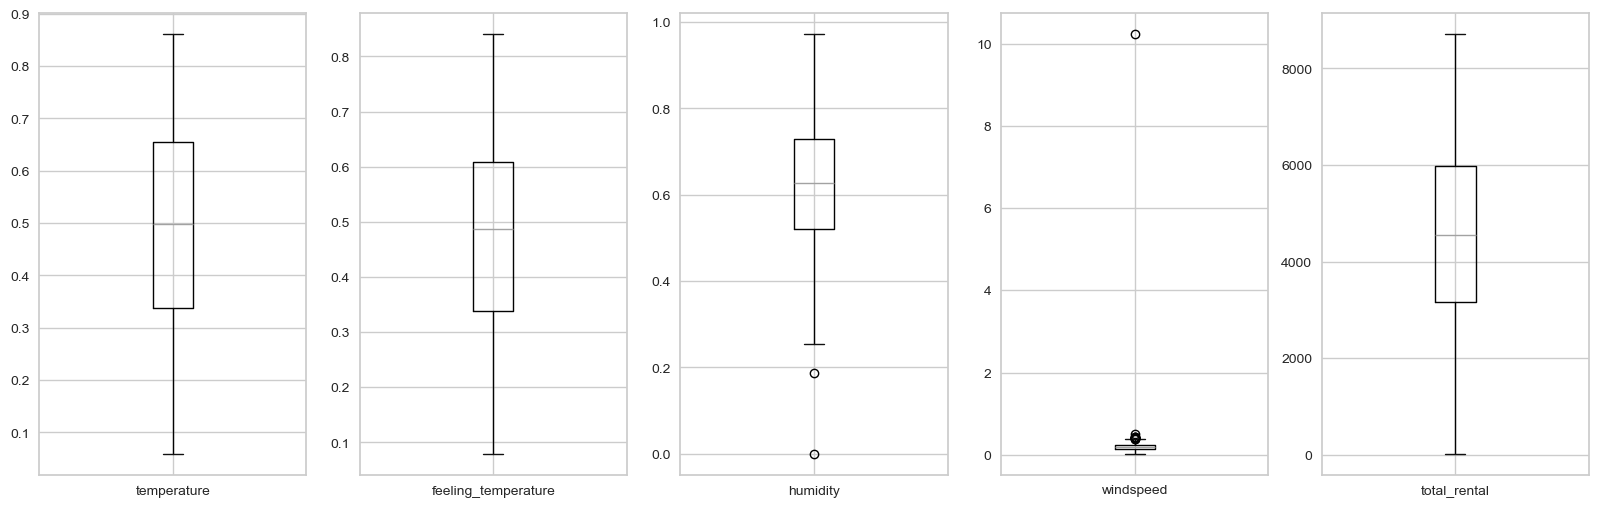

In [20]:
outliers_ds = ds[numerical_cols]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,6))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    # Box plot
    outliers_ds.boxplot(column=col, ax=axes[i])

    # Calculating outliers
    Q1 = outliers_ds[col].quantile(0.25)
    Q3 = outliers_ds[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Finding outlier values
    outliers = outliers_ds[(outliers_ds[col] < lower_bound) | (outliers_ds[col] > upper_bound)][col]

    # Printing outlier values
    if not outliers.empty:
        print(f'Outliers in {col}: {outliers.values}')

for j in range(len(numerical_cols), len(axes)):
    axes[j].axis('off')

plt.show()

- 'hum' has 2 outliers.
- 'winspeed' has 13 outliers. While others stand very close to each other, one outlier looks extreme above 10.

Outliers will be removed with different combinations of quantile ranges, taking into account the performance of the models. 

### Pairplot: linear relationships among numerical features

<Figure size 1000x500 with 0 Axes>

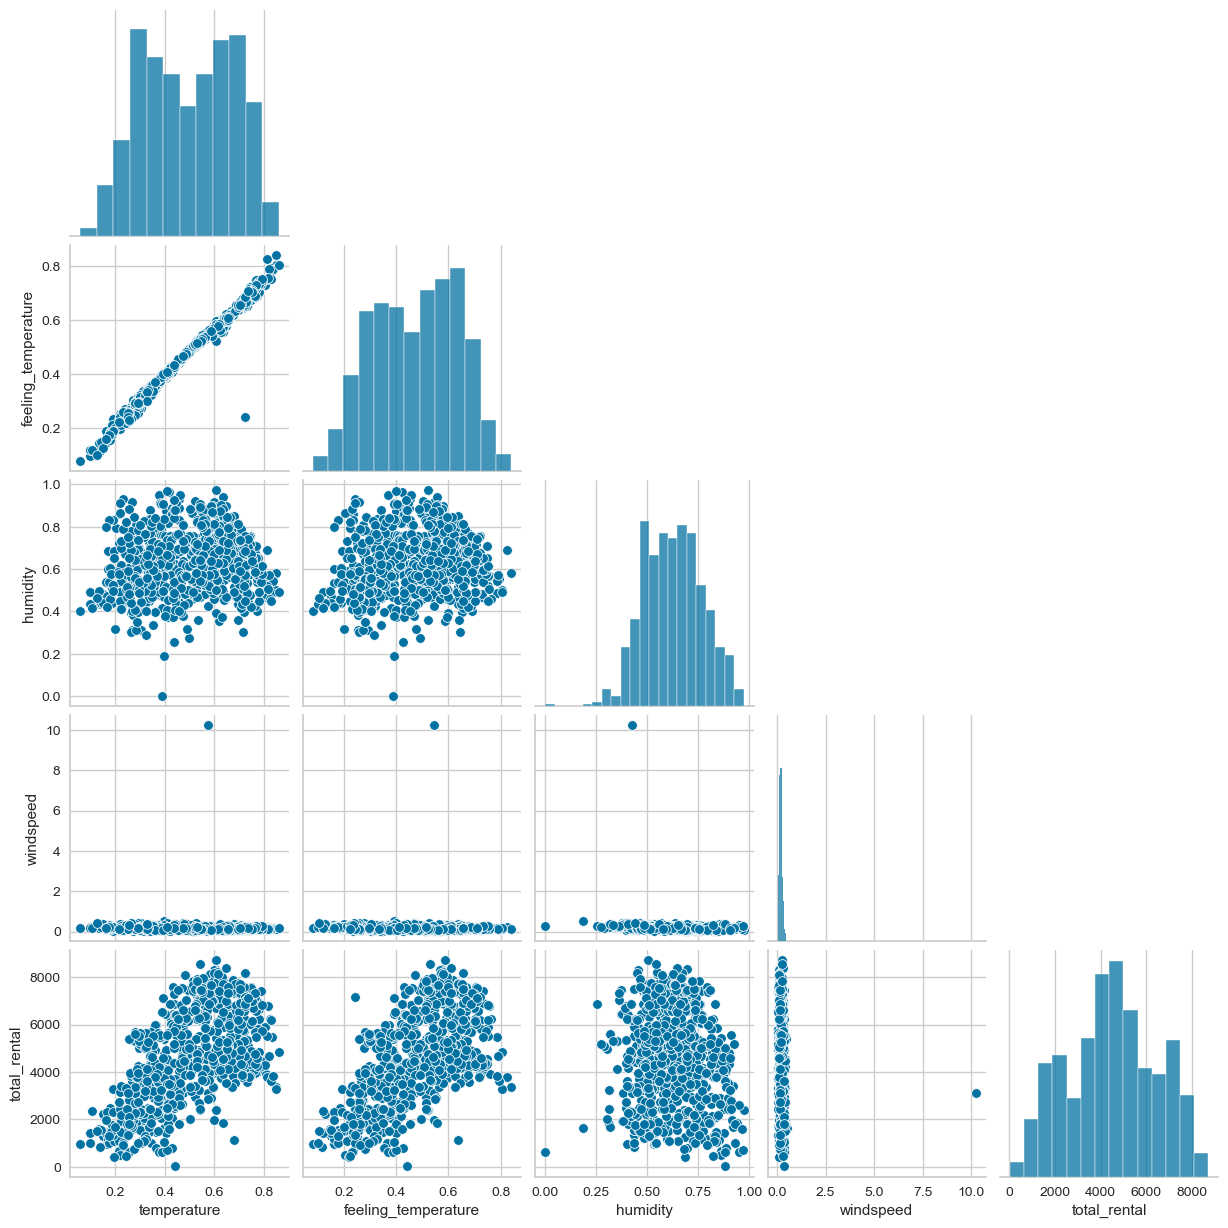

In [21]:
# Create a pairplot to see where there is potential linear relation between numerical features
plt.figure(figsize=(10, 5))
sns.pairplot(ds[numerical_cols], corner=True)

plt.show()

- While multicollinearity is less of a concern in tree-based models compared to linear models, it's still important to be aware of it and its potential implications, especially in terms of model interpretability. 'feeling_temperature' and 'temperature' have linear relation that can cause high correlation. Correlation matrix will show the relation between them clearly.

### 'schoolday' missing values: The relation with 'workingday' column

In [22]:
# View the rows, if the value of 'schoolday' column, excluding missing values, matches with 'workingday' column 
similar_values = ds[ds['schoolday'].isin(ds['workingday'])]
similar_values

,instant,date,season,year,month,day,holiday,weekday,workingday,schoolday,weather_condition,temperature,feeling_temperature,humidity,windspeed,casual,registered,total_rental
0,1,2011-01-01,Spring,2011,Jan,1,no,Saturday,no,no,Mist & Cloudy,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,Spring,2011,Jan,2,no,Sunday,no,no,Mist & Cloudy,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,Spring,2011,Jan,3,no,Monday,yes,yes,Clear & Few clouds,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,Spring,2011,Jan,4,no,Tuesday,yes,yes,Clear & Few clouds,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,Spring,2011,Jan,5,no,Wednesday,yes,yes,Clear & Few clouds,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,727,2012-12-27,Spring,2012,Dec,27,no,Thursday,yes,yes,Mist & Cloudy,0.254167,0.226642,0.652917,0.350133,247,1867,2114
728,728,2012-12-28,Spring,2012,Dec,28,no,Friday,yes,yes,Mist & Cloudy,0.253333,0.255046,0.590000,0.155471,644,2451,3095
729,729,2012-12-29,Spring,2012,Dec,29,no,Saturday,no,no,Mist & Cloudy,0.253333,0.242400,0.752917,0.124383,159,1182,1341
730,730,2012-12-30,Spring,2012,Dec,30,no,Sunday,no,no,Clear & Few clouds,0.255833,0.231700,0.483333,0.350754,364,1432,1796


454 rows matched.

In [23]:
# Show the count of non-missing values in 'schoolday' to double check
ds.schoolday.notnull().sum()

454

In [24]:
# Count of rows where weekday is weekend and schoolday is yes 
weekend_schoolday_yes_count = ds[(ds['weekday'].isin(['Saturday', 'Sunday'])) & (ds['schoolday'] == 'yes')].shape[0]

print("Weekend and Schoolday 'Yes':", weekend_schoolday_yes_count)

Weekend and Schoolday 'Yes': 0


- Before deciding whether to impute the 'schoolday' column, we wanted to explore its relationship with the 'workingday' column. Based on the analysis, we found that where 'working day' is 1, 'schoolday' is also consistently 1, and where 'working day' is 0, 'schoolday' is consistently 0. Therefore, since the values in the 'schoolday' column mirror those in the 'working day' column, we concluded that the 'schoolday' column can be safely removed.

- Replacing missing values based on the 'weekday' column might seem like a good idea, but looking at the data, it's clear this won't give us any new useful information for the models. It's because when it's a weekday, 'schoolday' is marked 'yes', and on weekends, it's 'no'. This is basically the same as what we already know from the 'workingday' column.

## DATA EXPLORATION

### Trend Analysis: 2012 is better than 2021? Which months have the highest count of rentals?

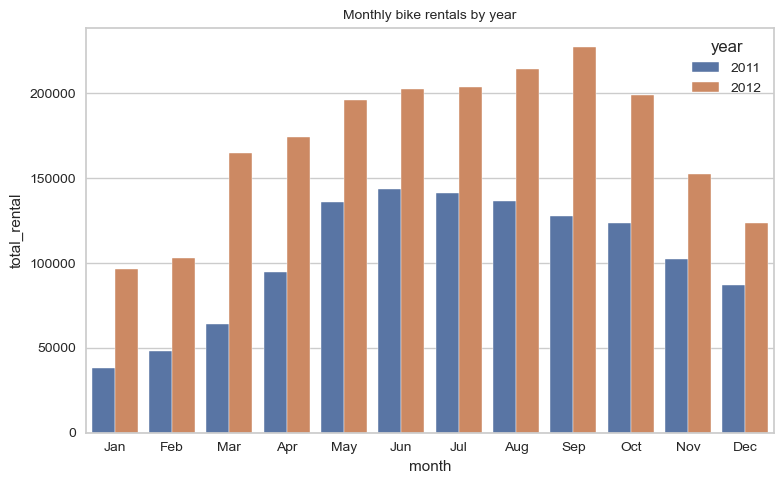

In [25]:
monthly_rentals = ds.groupby(['year', 'month'])['total_rental'].sum().reset_index()

month_order = list(calendar.month_abbr)[1:]

fig, axs = plt.subplots(1, 1, figsize=(8, 5))

sns.barplot(data=monthly_rentals, x="month", y="total_rental", hue="year", ax=axs, ci=None, palette='deep', order=month_order)
axs.set_title('Monthly bike rentals by year', fontsize=10)

plt.tight_layout()
plt.show()


Monthly Trends:
- Monthly bike rentals vary throughout the year, with some months experiencing higher rental counts compared to others.
- There is a noticeable increase in rentals during months (April to September), which are typically associated with better weather conditions and more outdoor activities.
- Conversely, the colder months (October to March) show a decrease in rentals, possibly due to less favorable weather conditions for biking.
- Understanding these monthly variations can help in optimizing bike rental services, such as adjusting inventory and marketing efforts to meet changing demand patterns throughout the year.

Yearly Trends:
- There is an overall increasing trend in bike rentals from 2011 to 2012, as evident from the higher rental counts in most months in 2012 compared to 2011.
- This increase could be attributed to various factors such as increasing popularity of biking, improved infrastructure, and expanded bike-sharing programs over time.


### Visualizing total rentals by 'season', 'holiday', 'weekday', and 'workingday'

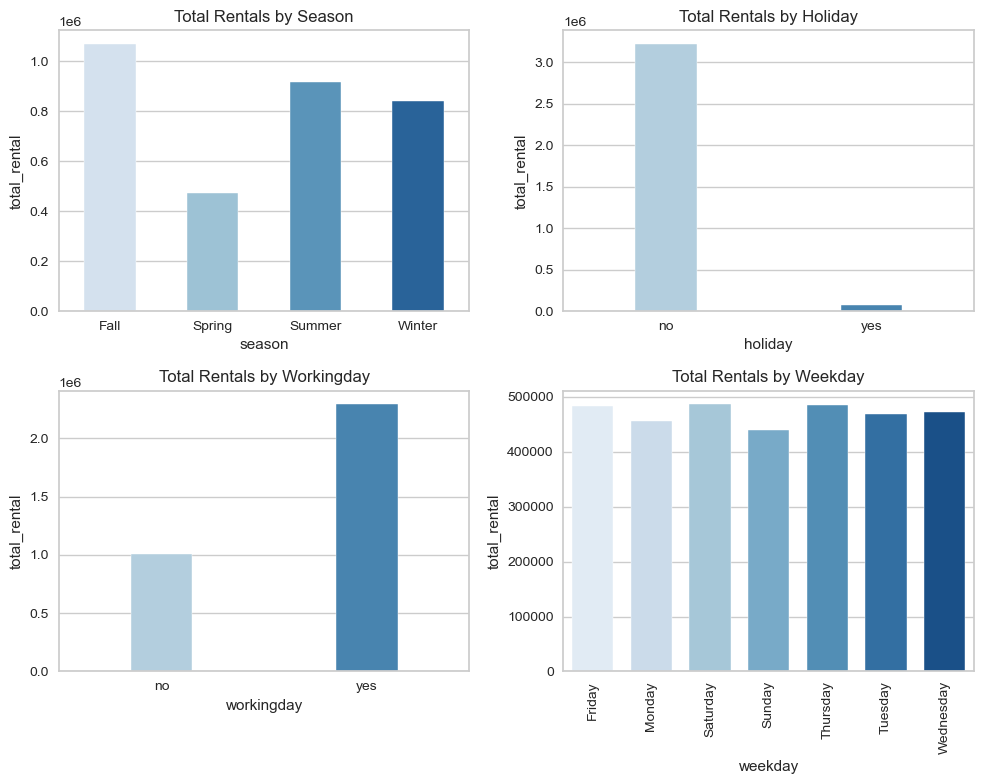

In [26]:
season_agg = ds.groupby('season')['total_rental'].sum().reset_index()
holiday_agg = ds.groupby('holiday')['total_rental'].sum().reset_index()
workingday_agg = ds.groupby('workingday')['total_rental'].sum().reset_index()
weekday_agg = ds.groupby('weekday')['total_rental'].sum().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.barplot(x='season', y='total_rental', data=season_agg, ax=axes[0, 0], palette='Blues', width=0.5)
axes[0, 0].set_title('Total Rentals by Season')

sns.barplot(x='holiday', y='total_rental', data=holiday_agg, ax=axes[0, 1], palette='Blues', width=0.3)
axes[0, 1].set_title('Total Rentals by Holiday')

sns.barplot(x='workingday', y='total_rental', data=workingday_agg, ax=axes[1, 0], palette='Blues', width=0.3)
axes[1, 0].set_title('Total Rentals by Workingday')

sns.barplot(x='weekday', y='total_rental', data=weekday_agg, ax=axes[1, 1], palette='Blues', width=0.7)
axes[1, 1].set_title('Total Rentals by Weekday')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Season:
- Fall has the highest total rentals, followed by Summer, Winter and Spring.
- Fall and Summer seasons seem to be the peak times for rentals, likely due to more favorable weather conditions for outdoor activities.

Holiday:
- There is a significant drop in total rentals on holidays compared to non-holidays.
- This suggests that people tend to rent bikes less frequently on holidays, possibly due to alternative leisure activities or travel.

Workingday:
- On working days, the total rentals are higher compared to non-working days.
- This indicates that the demand for bike rentals is significantly higher on days when people typically work, possibly for commuting to work or running errands.

Weekday:
- There is a relatively consistent distribution of rentals across weekdays.
- Saturday, Friday, and Thursday have slightly higher rental counts compared to other weekdays.
- Saturday and Sunday, although part of the weekend, do not show significantly higher rental counts compared to weekdays.
- This suggests that the demand for bike rentals remains relatively stable throughout the weekdays, with some fluctuations on specific days.

### How 'humidity', 'windspeed', 'temperature', and 'feeling temperature' vary with respect to the seasons?

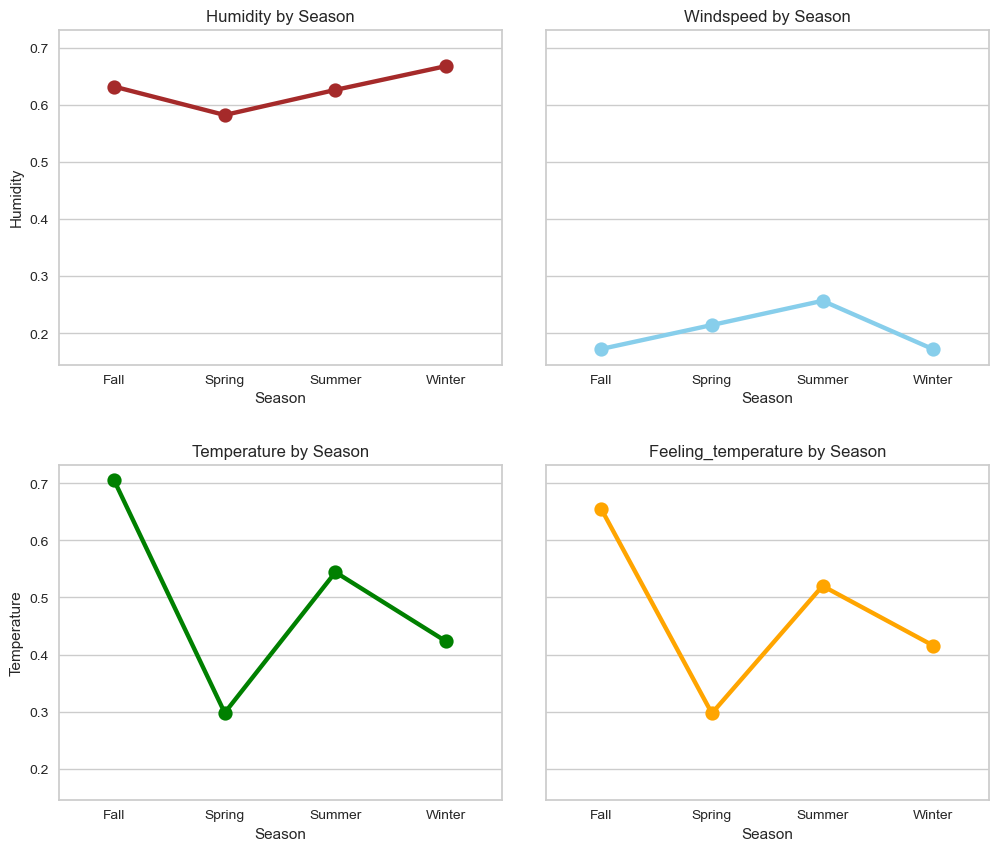

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

plt.subplots_adjust(wspace=0.1, hspace=0.3)

variables = ["humidity", "windspeed", "temperature", "feeling_temperature"]
colors = ['blue', 'green', 'red', 'orange']

for i, var in enumerate(variables):
    sns.pointplot(data=ds, x="season", y=var, ax=axes[i//2, i%2], ci=None, color=colors[i])
    axes[i//2, i%2].set_title(f"{var.capitalize()} by Season")
    axes[i//2, i%2].set_xlabel('Season')
    axes[i//2, i%2].set_ylabel(var.capitalize())

plt.show()

'humidity':
- Humidity exhibits slight fluctuations across the seasons, with the highest levels observed during winter.
- This suggests that winter months typically experience higher levels of moisture in the air.

'windspeed':
- Windspeed is lowest during fall and winter, reaching its peak in summer.
- This pattern indicates that fall and winter are characterized by calmer weather conditions, while summer experiences stronger winds.

'Temperature':
- The temperature variation among seasons aligns with the trend observed in rental counts, indicating a relationship between weather conditions and bike rentals.
- Fall records the highest total rentals and highest temperatures, followed by summer, winter, and spring.
- This implies that favorable weather conditions contribute to increased bike rentals.

'feeling_temperature':
- Similar to temperature, feeling temperature follows the same seasonal sequence, corroborating the influence of weather on rental patterns.

## Data Cleaning & Imputation

- Drop unnecessary columns('instant', 'date', 'casual', 'registered', 'schoolday')
- Remove the duplicated row
- Impute missing values for 'weekday' column
- 'feeling_temperature' column which is 0.99 correlated with the "temp" column, It will be dropped
- Remove outliers

In [28]:
# Create a modeling dataset from the original dataset to prevent data leakage. Apply data cleaning and preprocessing on the copied version
# Since the dataset is small and memory usage is not a concern, deep copy is applied
X = ds.copy(deep=True)
print(X.columns)

Index(['instant', 'date', 'season', 'year', 'month', 'day', 'holiday',
       'weekday', 'workingday', 'schoolday', 'weather_condition',
       'temperature', 'feeling_temperature', 'humidity', 'windspeed', 'casual',
       'registered', 'total_rental'],
      dtype='object')


### Drop unnecessary columns

In [29]:
X = X.drop(['instant', 'date', 'casual', 'registered', 'schoolday'], axis=1)
print(X.columns)

Index(['season', 'year', 'month', 'day', 'holiday', 'weekday', 'workingday',
       'weather_condition', 'temperature', 'feeling_temperature', 'humidity',
       'windspeed', 'total_rental'],
      dtype='object')


Dropped finely.

### Drop the duplicated row

In [30]:
# Drop the duplicate rows 
X = X.drop_duplicates()

# Print number of the duplicated rows after the dropping
X.duplicated().sum()

0

Number of duplicated rows are 0. 

In [31]:
# Check the number of rows
X.shape

(731, 13)

Total rows dropped from 732 to 731. Done successfully.

### Handling missing values in the 'weekday' column

In [32]:
# Check the counts of values to decide imputation method
X['weekday'].value_counts()

weekday
Monday       105
Saturday     105
Sunday       104
Thursday     104
Tuesday      104
Wednesday    104
Friday       103
Name: count, dtype: int64

The most frequent values in the dataset for the 'weekday' column is Monday, followed by Saturday.

In [33]:
# Find the indices of missing values
missing_indices = X.index[X['weekday'].isna()].tolist()

# Replace one missing value with 'Saturday' and the other with 'Monday'
X.loc[missing_indices[0], 'weekday'] = 'Saturday'
X.loc[missing_indices[1], 'weekday'] = 'Monday'

X['weekday'].value_counts()

weekday
Monday       106
Saturday     106
Sunday       104
Thursday     104
Tuesday      104
Wednesday    104
Friday       103
Name: count, dtype: int64

Since there are two missing values, we assigned one for Monday and one for Saturday (corresponding mode values).

### Filtering the outliers

In [34]:
for col in numerical_cols:
    Q1, Q3 = X[col].quantile([0.15, 0.85]) # 10-90, 5-95, 15-85(best) 
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)].index

    # Drop outliers
    X.drop(outliers, inplace=True)

I noticed that outliers for different quantile ranges give different results. For that, we decided to choose the range (15-85) that gives better training and test results. 

In [35]:
print(X.shape)

(728, 13)


With the range 0.15-0.85, 3 rows removed. 

## Data Preprocessing
- One-hot encoding is applied for 'season', 'year', 'month','weather_condition', 'weekday' columns.

### One-hot encoding

In [36]:
# Perform one-hot encoding
cols = ['season', 'year', 'month','weather_condition', 'weekday', 'holiday', 'workingday']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

Since the decision tree models don't assume any ordinal relationship between categories, One hot encoding is applied. For Lasso Regression that can benefit from ordinal information or have assumptions about the ordinality of features, OrdinalEncoder is applied. 
Since the results are not affected by encoding type for Lasso Regression, we used only One Hot Encoding. 

In [37]:
# Check the encoded variables
print(X.columns)
X.head()

Index(['season_Spring', 'season_Summer', 'season_Fall', 'season_Winter',
       'year_2011.0', 'year_2012.0', 'month_Jan', 'month_Feb', 'month_Mar',
       'month_Apr', 'month_May', 'month_Jun', 'month_Jul', 'month_Aug',
       'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec', 'day', 'holiday_no',
       'holiday_yes', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Monday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday',
       'weekday_Friday', 'workingday_no', 'workingday_yes',
       'weather_condition_Mist & Cloudy',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature',
       'feeling_temperature', 'humidity', 'windspeed', 'total_rental'],
      dtype='object')


,season_Spring,season_Summer,season_Fall,season_Winter,year_2011.0,year_2012.0,month_Jan,month_Feb,month_Mar,month_Apr,...,workingday_no,workingday_yes,weather_condition_Mist & Cloudy,weather_condition_Clear & Few clouds,weather_condition_Light snow & Rain,temperature,feeling_temperature,humidity,windspeed,total_rental
0,1,0,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0.344167,0.363625,0.805833,0.160446,985
1,1,0,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0.363478,0.353739,0.696087,0.248539,801
2,1,0,0,0,1,0,1,0,0,0,...,0,1,0,1,0,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,0,0,1,0,1,0,0,0,...,0,1,0,1,0,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,0,0,1,0,1,0,0,0,...,0,1,0,1,0,0.226957,0.229270,0.436957,0.186900,1600


All looks fine.

### Correlation matrix

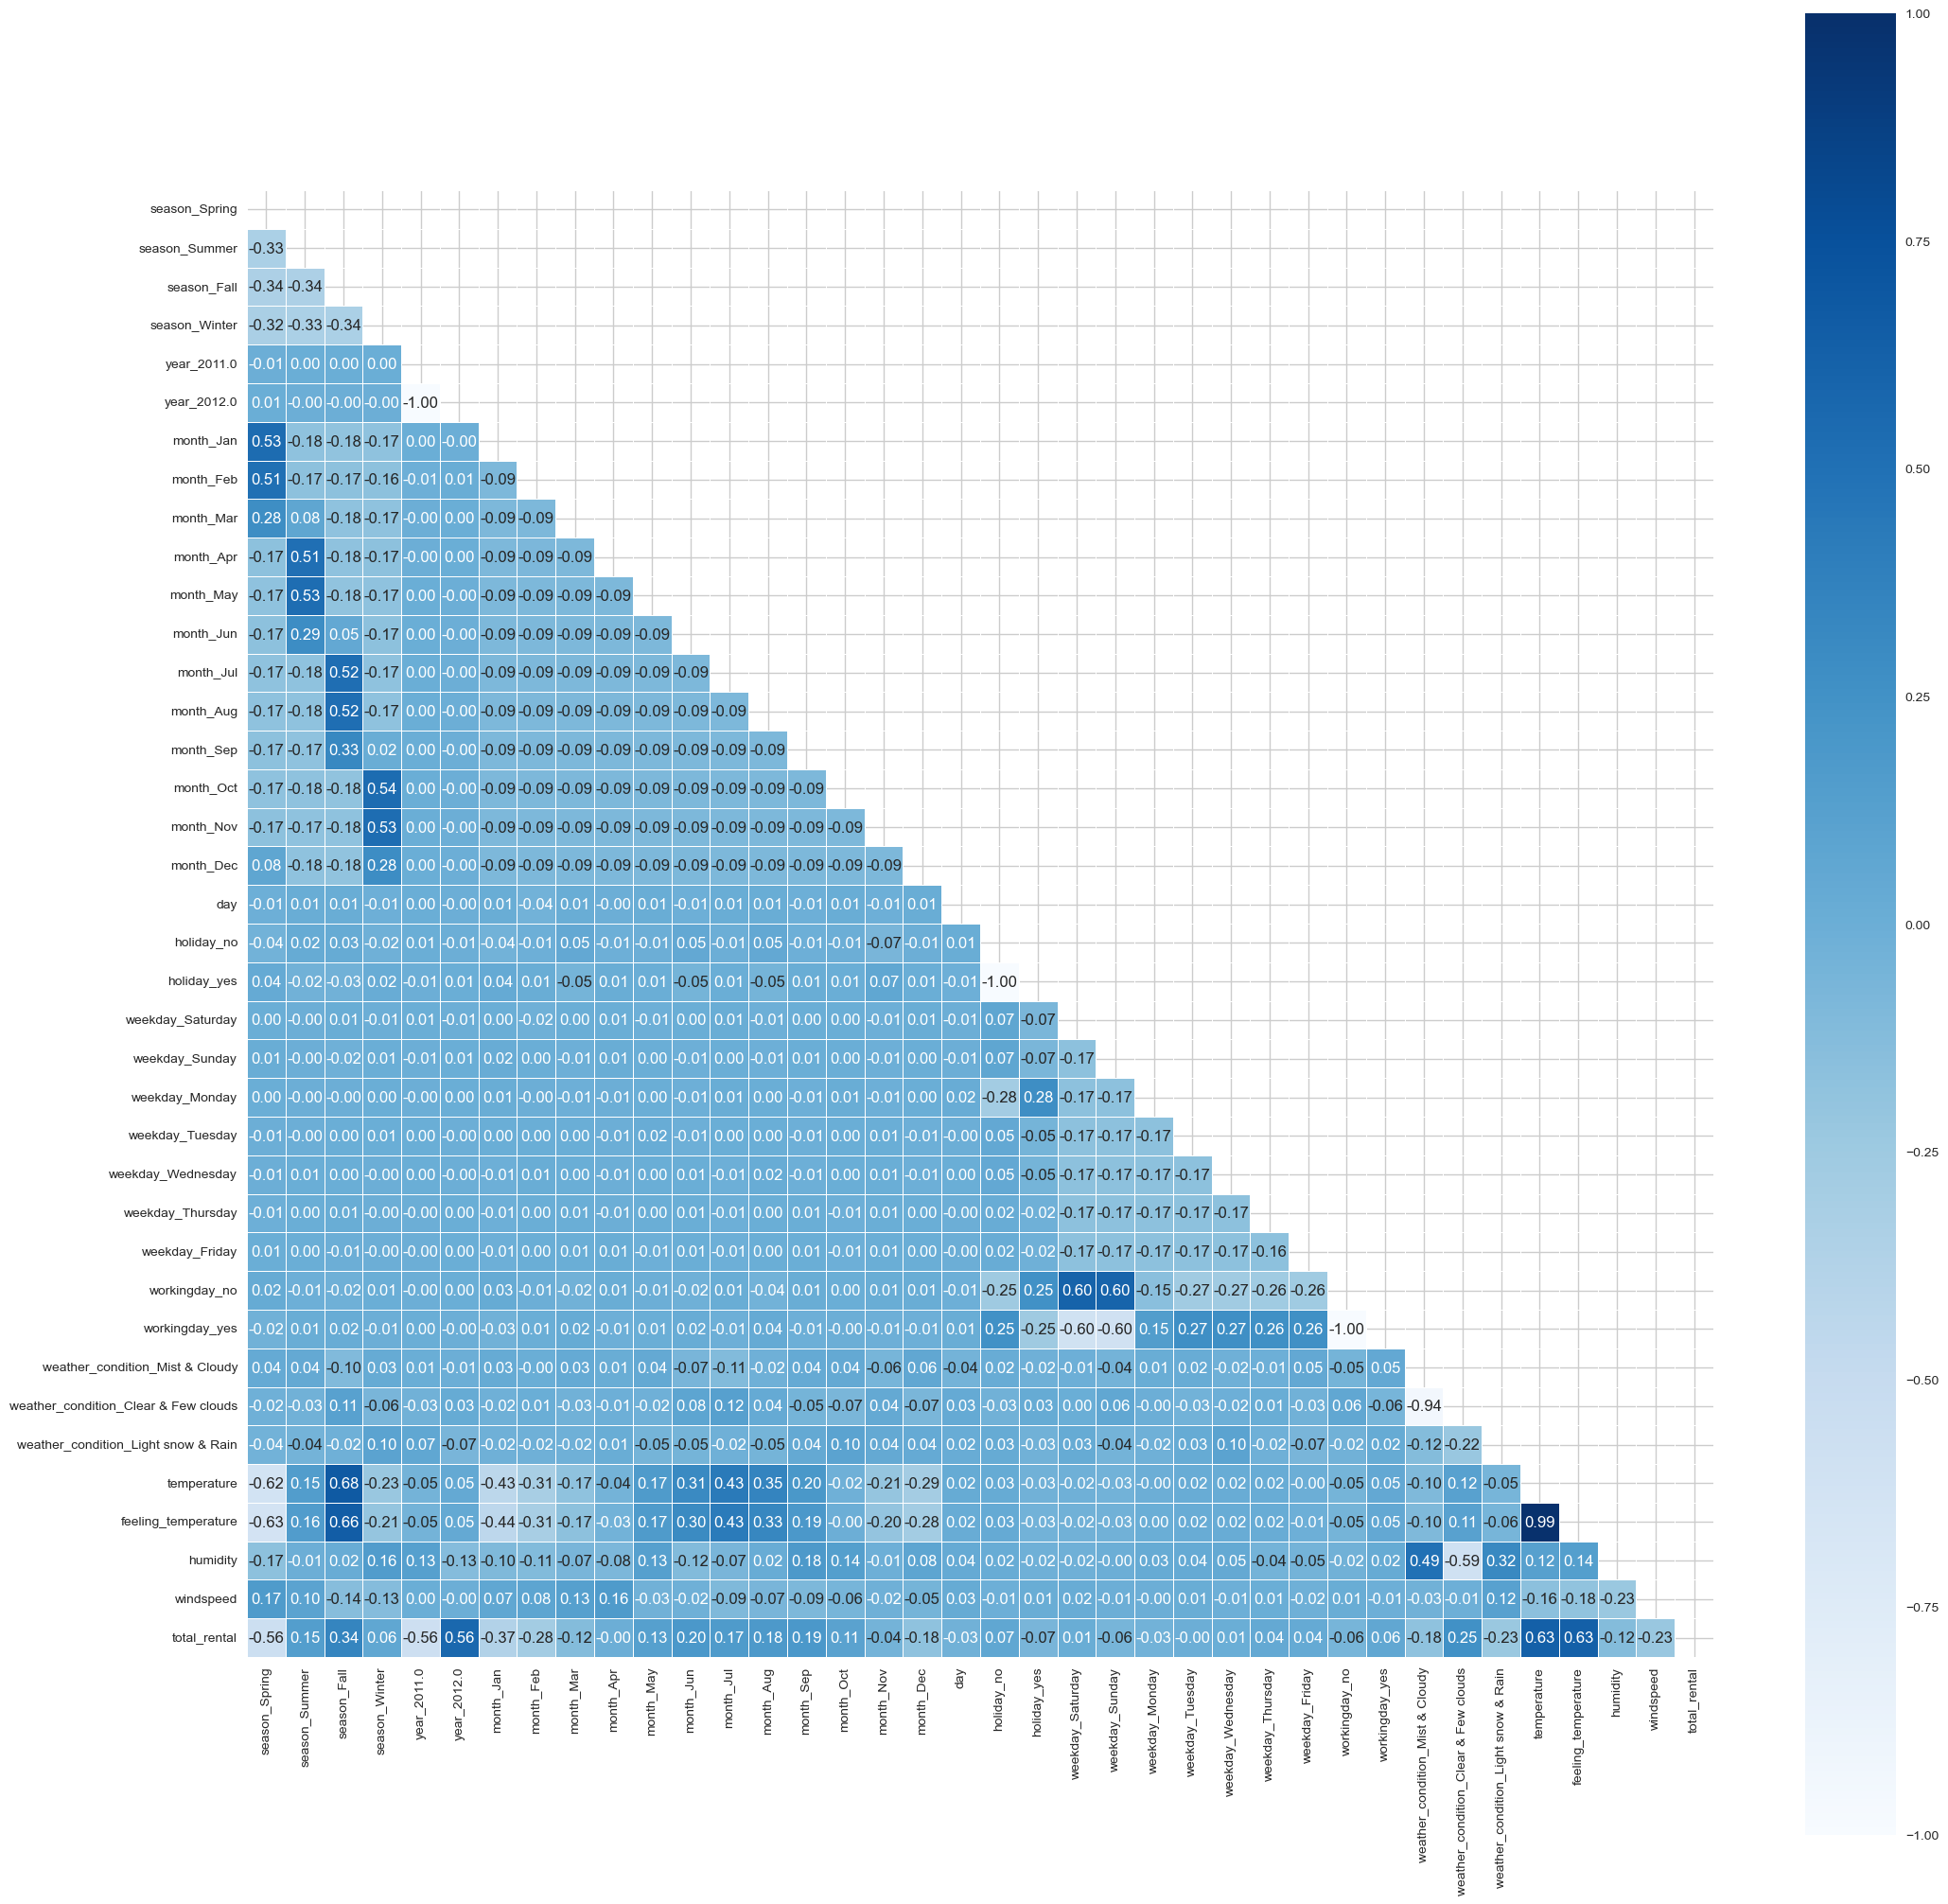

In [38]:
# Calculate correlation matrix
correlation_matrix = X.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the size of the figure
plt.figure(figsize=(25, 25))

# Plot the heatmap
sns.heatmap(correlation_matrix, cmap='Blues', mask=mask,
                square=True,
                linewidths=.5,
                vmin=-1,
                vmax=1,
                annot=True,
                fmt=".2f")
plt.show()

The 'temperature' and 'feeling temperature' are correlated with 0.99 as we observed in the beginning. The “feeling temperature” is an indicator that includes air temperature, humidity and wind speed. We have 'humidity' and ' 'windspeed' columns already. we decided to drop 'feeling_temperature'.

In [39]:
X = X.drop(['feeling_temperature'], axis=1)
print(X.columns)

Index(['season_Spring', 'season_Summer', 'season_Fall', 'season_Winter',
       'year_2011.0', 'year_2012.0', 'month_Jan', 'month_Feb', 'month_Mar',
       'month_Apr', 'month_May', 'month_Jun', 'month_Jul', 'month_Aug',
       'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec', 'day', 'holiday_no',
       'holiday_yes', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Monday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday',
       'weekday_Friday', 'workingday_no', 'workingday_yes',
       'weather_condition_Mist & Cloudy',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature', 'humidity',
       'windspeed', 'total_rental'],
      dtype='object')


## Data Preparation



### Feature engineering

In [40]:
# Check the percentiles for columns to create bins for 'temperature', 'humidity', 'windspeed' columns
X[['temperature', 'humidity', 'windspeed']].describe()

,temperature,humidity,windspeed
count,728.000000,728.000000,728.000000
mean,0.495556,0.629638,0.189685
std,0.183328,0.139650,0.076371
min,0.059130,0.254167,0.022392
25%,0.336458,0.522396,0.134798
50%,0.499167,0.628333,0.180348
75%,0.655833,0.730625,0.233028
max,0.861667,0.972500,0.441563


In [41]:
# Define label and bins based on the percentiles
temperature_bins = [0, 0.34, 0.5, 1.0]
temperature_labels = ['Cold', 'Moderate', 'Hot']
temperature_category = pd.cut(X['temperature'], bins=temperature_bins, labels=temperature_labels)
X['temperature_category'] = temperature_category

humidity_bin_edges = [-1, 0.52, 0.63, 1.0]
humidity_bin_labels = ['Low', 'Moderate', 'High']
humidity_category = pd.cut(X['humidity'], bins=humidity_bin_edges, labels=humidity_bin_labels)
X['humidity_category'] = humidity_category

wind_bin_edges = [-1, 0.13, 0.18, 1.0]
wind_bin_labels = ['Low', 'Moderate', 'High']
wind_speed_category = pd.cut(X['windspeed'], bins=wind_bin_edges, labels=wind_bin_labels, include_lowest=True)
X['wind_speed_category'] = wind_speed_category

# Drop the original columns
X.drop(columns=['temperature', 'humidity', 'windspeed'], inplace=True)

In [42]:
# Check unique values to confirm
print(X['temperature_category'].unique())
print(X['humidity_category'].unique())
print(X['wind_speed_category'].unique())

['Moderate', 'Cold', 'Hot']
Categories (3, object): ['Cold' < 'Moderate' < 'Hot']
['High', 'Low', 'Moderate']
Categories (3, object): ['Low' < 'Moderate' < 'High']
['Moderate', 'High', 'Low']
Categories (3, object): ['Low' < 'Moderate' < 'High']


Unique values are the ones we assigned to the bins. Good!

In [43]:
# Encode new categorical values into dummy variables
cols = ['temperature_category', 'humidity_category', 'wind_speed_category']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [44]:
# Confirm
X.tail()

,season_Spring,season_Summer,season_Fall,season_Winter,year_2011.0,year_2012.0,month_Jan,month_Feb,month_Mar,month_Apr,...,total_rental,temperature_category_Cold,temperature_category_Moderate,temperature_category_Hot,humidity_category_Low,humidity_category_Moderate,humidity_category_High,wind_speed_category_Low,wind_speed_category_Moderate,wind_speed_category_High
727,1,0,0,0,0,1,0,0,0,0,...,2114,1,0,0,0,0,1,0,0,1
728,1,0,0,0,0,1,0,0,0,0,...,3095,1,0,0,0,1,0,0,1,0
729,1,0,0,0,0,1,0,0,0,0,...,1341,1,0,0,0,0,1,1,0,0
730,1,0,0,0,0,1,0,0,0,0,...,1796,1,0,0,1,0,0,0,0,1
731,1,0,0,0,0,1,0,0,0,0,...,2729,1,0,0,0,1,0,0,1,0


In [45]:
# Summary statistics for all variables after data preparation - Transpose
X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
season_Spring,728.0,0.245879,0.430903,0.0,0.0,0.0,0.0,1.0
season_Summer,728.0,0.251374,0.434101,0.0,0.0,0.0,1.0,1.0
season_Fall,728.0,0.258242,0.437969,0.0,0.0,0.0,1.0,1.0
season_Winter,728.0,0.244505,0.430089,0.0,0.0,0.0,0.0,1.0
year_2011.0,728.0,0.497253,0.500336,0.0,0.0,0.0,1.0,1.0
year_2012.0,728.0,0.502747,0.500336,0.0,0.0,1.0,1.0,1.0
month_Jan,728.0,0.085165,0.279319,0.0,0.0,0.0,0.0,1.0
month_Feb,728.0,0.076923,0.266653,0.0,0.0,0.0,0.0,1.0
month_Mar,728.0,0.083791,0.277265,0.0,0.0,0.0,0.0,1.0
month_Apr,728.0,0.081044,0.273090,0.0,0.0,0.0,0.0,1.0


In [46]:
# Correlation matrix for target(total_rental) column after data preparation
correlation_matrix = X.corr()['total_rental'].sort_values(ascending=False)

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
total_rental                            1.000000
temperature_category_Hot                0.569912
year_2012.0                             0.564704
season_Fall                             0.344931
weather_condition_Clear & Few clouds    0.253227
month_Jun                               0.195079
month_Sep                               0.194171
month_Aug                               0.181543
month_Jul                               0.165624
season_Summer                           0.146168
month_May                               0.131824
wind_speed_category_Moderate            0.130109
wind_speed_category_Low                 0.118523
month_Oct                               0.108035
humidity_category_Moderate              0.105774
holiday_no                              0.069668
season_Winter                           0.062647
workingday_yes                          0.061115
weekday_Thursday                        0.040155
weekday_Friday                          0.035011


In [47]:
# Create the target variable
y = X['total_rental']

In [48]:
# Make sure target variable is correctly assigned
y

0       985
1       801
2      1349
3      1562
4      1600
       ... 
727    2114
728    3095
729    1341
730    1796
731    2729
Name: total_rental, Length: 728, dtype: int64

In [49]:
# Drop the target from the training data
X = X.drop(['total_rental'], axis=1)

In [50]:
# Check X has all the columns in the dataset except 'total_rental' column
X.columns

Index(['season_Spring', 'season_Summer', 'season_Fall', 'season_Winter',
       'year_2011.0', 'year_2012.0', 'month_Jan', 'month_Feb', 'month_Mar',
       'month_Apr', 'month_May', 'month_Jun', 'month_Jul', 'month_Aug',
       'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec', 'day', 'holiday_no',
       'holiday_yes', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Monday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday',
       'weekday_Friday', 'workingday_no', 'workingday_yes',
       'weather_condition_Mist & Cloudy',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature_category_Cold',
       'temperature_category_Moderate', 'temperature_category_Hot',
       'humidity_category_Low', 'humidity_category_Moderate',
       'humidity_category_High', 'wind_speed_category_Low',
       'wind_speed_category_Moderate', 'wind_speed_category_High'],
      dtype='object')

## MODELING

In [51]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=random_state) 

In [52]:
# Check shape of the splits to confirm
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (582, 42)
Shape of X_test: (146, 42)
Shape of y_train: (582,)
Shape of y_test: (146,)


### Random Forest Regressor

In [53]:
# Check parameters
help(RandomForestRegressor)

Help on class RandomForestRegressor in module sklearn.ensemble._forest:

class RandomForestRegressor(ForestRegressor)
 |  RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and uses averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  For a comparison between tree-based ensemble models see the example
 |  :ref:`sphx_glr_auto_examp

#### Hyperparameter Tuning - Optuna

In [54]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators',50, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    # Create a RandomForest regressor with trial parameters
    rf_reg = RandomForestRegressor(random_state=random_state, **params)

    # Calculate cross-validated R-squared score using KFold
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    cv_score = cross_val_score(rf_reg, X_train, y_train, cv=cv, scoring='r2')
    score = cv_score.mean()
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and the best score
best_params_rf = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params_rf)
print("Best R-squared Score:", best_score)

[I 2024-04-01 19:03:40,062] A new study created in memory with name: no-name-c40fa021-9edf-4796-a8de-03c27c95ebf4
[I 2024-04-01 19:03:40,881] Trial 0 finished with value: 0.7485374529266604 and parameters: {'n_estimators': 143, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.7485374529266604.
[I 2024-04-01 19:03:41,456] Trial 1 finished with value: 0.6279160266443291 and parameters: {'n_estimators': 120, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.7485374529266604.
[I 2024-04-01 19:03:41,992] Trial 2 finished with value: 0.7454200235495658 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.7485374529266604.
[I 2024-04-01 19:03:42,326] Trial 3 finished with value: 0.6137508290078779 and parameters: {'n_estimators': 77, 'max_depth': 3, 'min_sa

Best Parameters: {'n_estimators': 140, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best R-squared Score: 0.7835843229782511


In [55]:
# Instantiate a RandomForestRegressor model with the best hyperparameters
rf_reg = RandomForestRegressor(**best_params_rf, random_state=random_state)

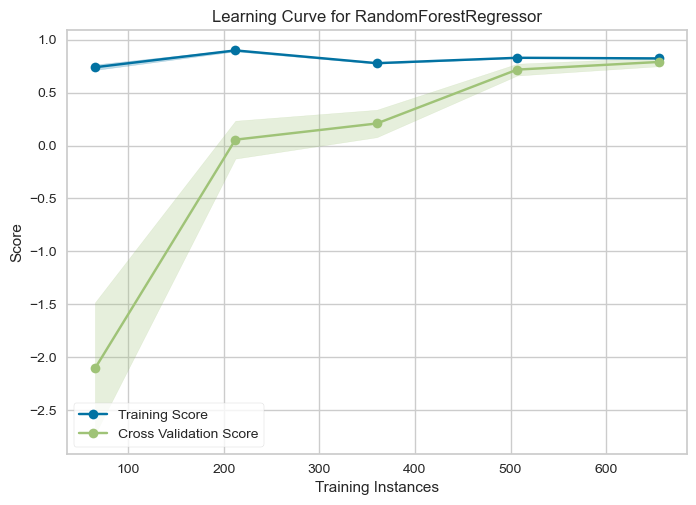

In [56]:
# Plot the learning curve
plot_learning_curve(X, y, rf_reg)

https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

In [57]:
# Fit the model to the training data
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_split=3,
                      n_estimators=140, random_state=2024)

In [58]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in rf_reg.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in rf_reg.feature_importances_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

,Feature,Coefficient,AbsCoefficient
5,year_2012.0,0.173902,0.173902
4,year_2011.0,0.146269,0.146269
0,season_Spring,0.143032,0.143032
33,temperature_category_Cold,0.141642,0.141642
35,temperature_category_Hot,0.111059,0.111059
6,month_Jan,0.042768,0.042768
2,season_Fall,0.029232,0.029232
31,weather_condition_Clear & Few clouds,0.024972,0.024972
32,weather_condition_Light snow & Rain,0.018629,0.018629
34,temperature_category_Moderate,0.017062,0.017062


In [59]:
# Evaluate RandomForestRegressor and compare train and test results
evaluate_model(rf_reg, X_train, y_train, X_test, y_test)

+--------------------+---------------+--------------+
| Metric             |   Train Score |   Test Score |
+====================+===============+==============+
| Execution Time (s) |        0.0095 |       0.0095 |
+--------------------+---------------+--------------+
| MAE                |      608.1878 |     714.6712 |
+--------------------+---------------+--------------+
| RMSE               |      800.6347 |     909.5567 |
+--------------------+---------------+--------------+
| R^2                |        0.8269 |       0.7835 |
+--------------------+---------------+--------------+
| Adjusted R^2       |        0.8134 |       0.6952 |
+--------------------+---------------+--------------+
| MAPE               |       50.4532 |      29.6013 |
+--------------------+---------------+--------------+
| Max Error          |     3838.0647 |    3283.0764 |
+--------------------+---------------+--------------+


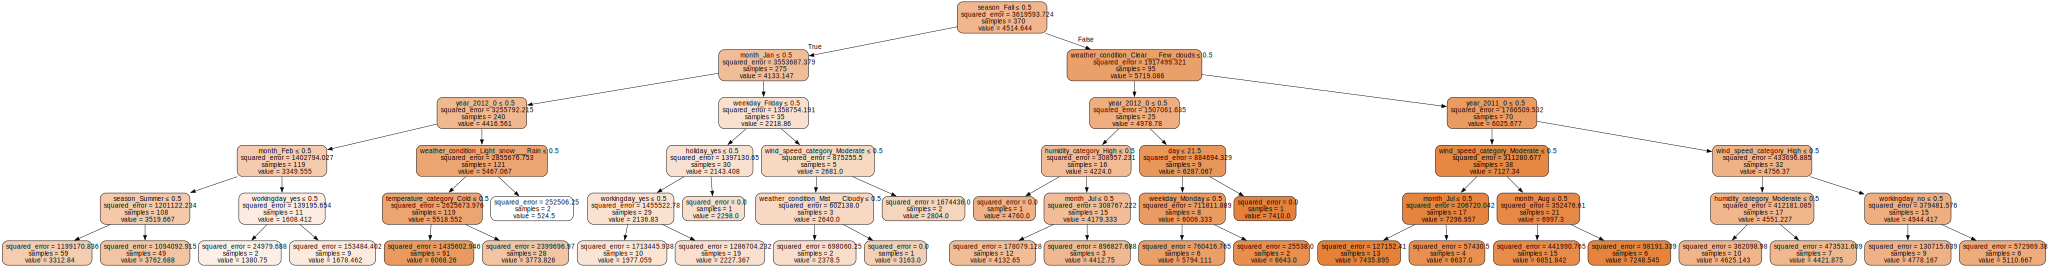

In [60]:
# Accessing one of the decision trees from the random forest
tree_in_forest = rf_reg.estimators_[4]

# Export the decision tree to Graphviz format
dot_data = tree.export_graphviz(tree_in_forest, out_file=None,
                                feature_names=[re.sub('[^a-zA-Z0-9_]', '_', feature) for feature in X_train.columns],
                                filled=True, rounded=True,
                                special_characters=True)

# Visualize the decision tree
graph = graphviz.Source(dot_data)
# graph.render("random_forest_tree")  # Optionally save the tree to a file
# graph.view()  # View the tree in the default viewer
graph

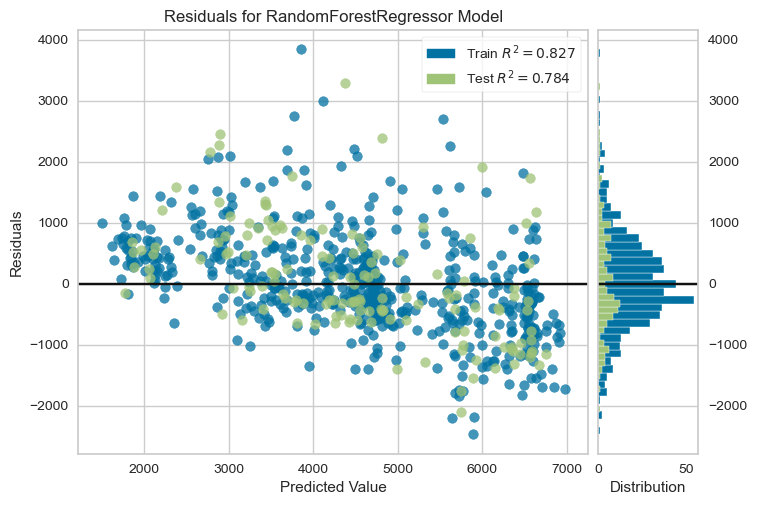

In [61]:
# Visualize residuals 
visualize_residuals(rf_reg, X_train, y_train, X_test, y_test)

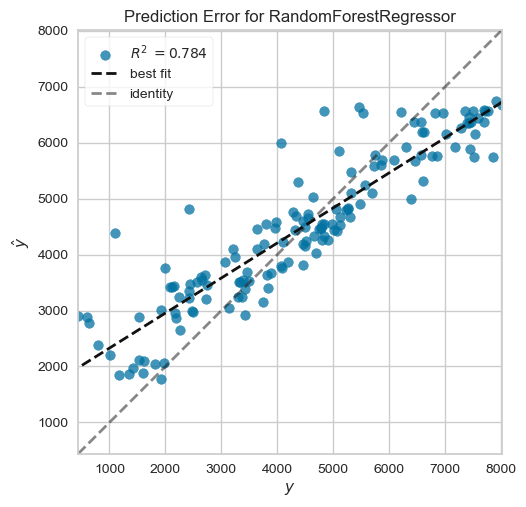

In [62]:
# Prediction error plot
visualize_prediction_error(rf_reg, X_train, y_train, X_test, y_test)

### XGBoost Regressor

In [63]:
help(xgb.XGBRegressor())

Help on XGBRegressor in module xgboost.sklearn object:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(*, objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror', **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : Optional[int]
 |          Number of gradient boosted trees.  Equivalent to number of boosting
 |          rounds.
 |  
 |      max_depth :  Optional[int]
 |          Maximum tree depth for base learners.
 |      max_leaves :
 |          Maximum number of leaves; 0 indicates no limit.
 |      max_bin :
 |          If using histogram-based algorithm, maximum number of bins per feature
 |      grow_policy :
 |          Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
 |          

#### Hyperparameter Tuning - Optuna

In [64]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'max_depth': trial.suggest_categorical('max_depth', [3, 6]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.75]),
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6, 0.8]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.03, 0.1]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [1, 10])
    }

    # Create an XGBoost regressor with trial parameters
    xg_reg = xgb.XGBRegressor(objective='reg:linear', random_state=random_state, **params)

    # Calculate cross-validated R-squared score
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    cv_score = cross_val_score(xg_reg, X_train, y_train, cv=cv, scoring='r2')
    score = cv_score.mean()
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and the best score
best_params_xg = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params_xg)
print("Best R-squared Score:", best_score)

[I 2024-04-01 19:04:15,097] A new study created in memory with name: no-name-9f29bb3a-fb0d-440c-bf33-9d538a6f3157
[I 2024-04-01 19:04:16,182] Trial 0 finished with value: 0.8154564400902922 and parameters: {'max_depth': 6, 'subsample': 0.75, 'n_estimators': 100, 'colsample_bytree': 0.6, 'learning_rate': 0.03, 'reg_lambda': 10}. Best is trial 0 with value: 0.8154564400902922.
[I 2024-04-01 19:04:16,503] Trial 1 finished with value: 0.741802018742501 and parameters: {'max_depth': 3, 'subsample': 0.75, 'n_estimators': 50, 'colsample_bytree': 0.8, 'learning_rate': 0.03, 'reg_lambda': 1}. Best is trial 0 with value: 0.8154564400902922.
[I 2024-04-01 19:04:17,427] Trial 2 finished with value: 0.8356477652628183 and parameters: {'max_depth': 6, 'subsample': 0.5, 'n_estimators': 100, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'reg_lambda': 1}. Best is trial 2 with value: 0.8356477652628183.
[I 2024-04-01 19:04:17,932] Trial 3 finished with value: 0.8493393759476158 and parameters: {'max_de

Best Parameters: {'max_depth': 3, 'subsample': 0.75, 'n_estimators': 100, 'colsample_bytree': 0.6, 'learning_rate': 0.1, 'reg_lambda': 1}
Best R-squared Score: 0.8511417226135837


In [65]:
# Instantiate a XGBoostRegressor model with the best hyperparameters
xg_reg = xgb.XGBRegressor(**best_params_xg, random_state=random_state)

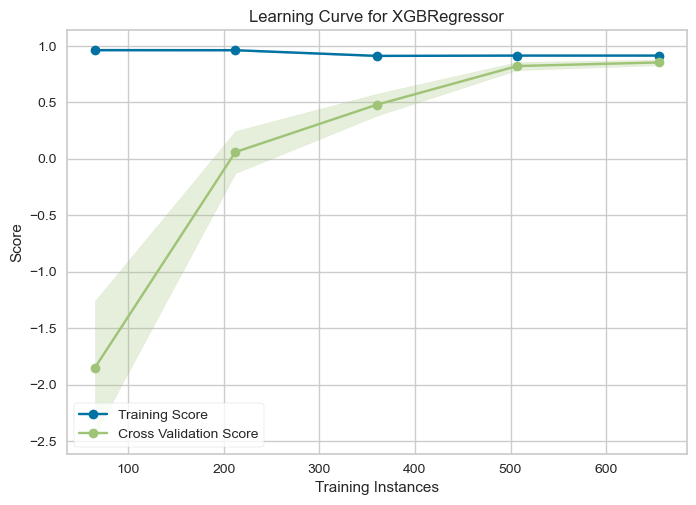

In [66]:
# Plot the learning curve
plot_learning_curve(X, y, xg_reg)

In [67]:
# Fit the model to the training data
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=2024, ...)

In [68]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in xg_reg.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in xg_reg.feature_importances_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

,Feature,Coefficient,AbsCoefficient
35,temperature_category_Hot,0.216023,0.216023
0,season_Spring,0.140160,0.140160
33,temperature_category_Cold,0.137265,0.137265
5,year_2012.0,0.112550,0.112550
4,year_2011.0,0.085526,0.085526
34,temperature_category_Moderate,0.037730,0.037730
3,season_Winter,0.033970,0.033970
32,weather_condition_Light snow & Rain,0.026844,0.026844
31,weather_condition_Clear & Few clouds,0.024330,0.024330
30,weather_condition_Mist & Cloudy,0.016756,0.016756


In [69]:
# Evaluate XGBoost Regressor and compare train and test results
evaluate_model(xg_reg, X_train, y_train, X_test, y_test)

+--------------------+---------------+--------------+
| Metric             |   Train Score |   Test Score |
+====================+===============+==============+
| Execution Time (s) |        0.0062 |       0.0062 |
+--------------------+---------------+--------------+
| MAE                |      395.0220 |     534.9792 |
+--------------------+---------------+--------------+
| RMSE               |      543.7840 |     740.4537 |
+--------------------+---------------+--------------+
| R^2                |        0.9202 |       0.8565 |
+--------------------+---------------+--------------+
| Adjusted R^2       |        0.9139 |       0.7980 |
+--------------------+---------------+--------------+
| MAPE               |       23.0624 |      18.1967 |
+--------------------+---------------+--------------+
| Max Error          |     2455.6035 |    3705.0244 |
+--------------------+---------------+--------------+


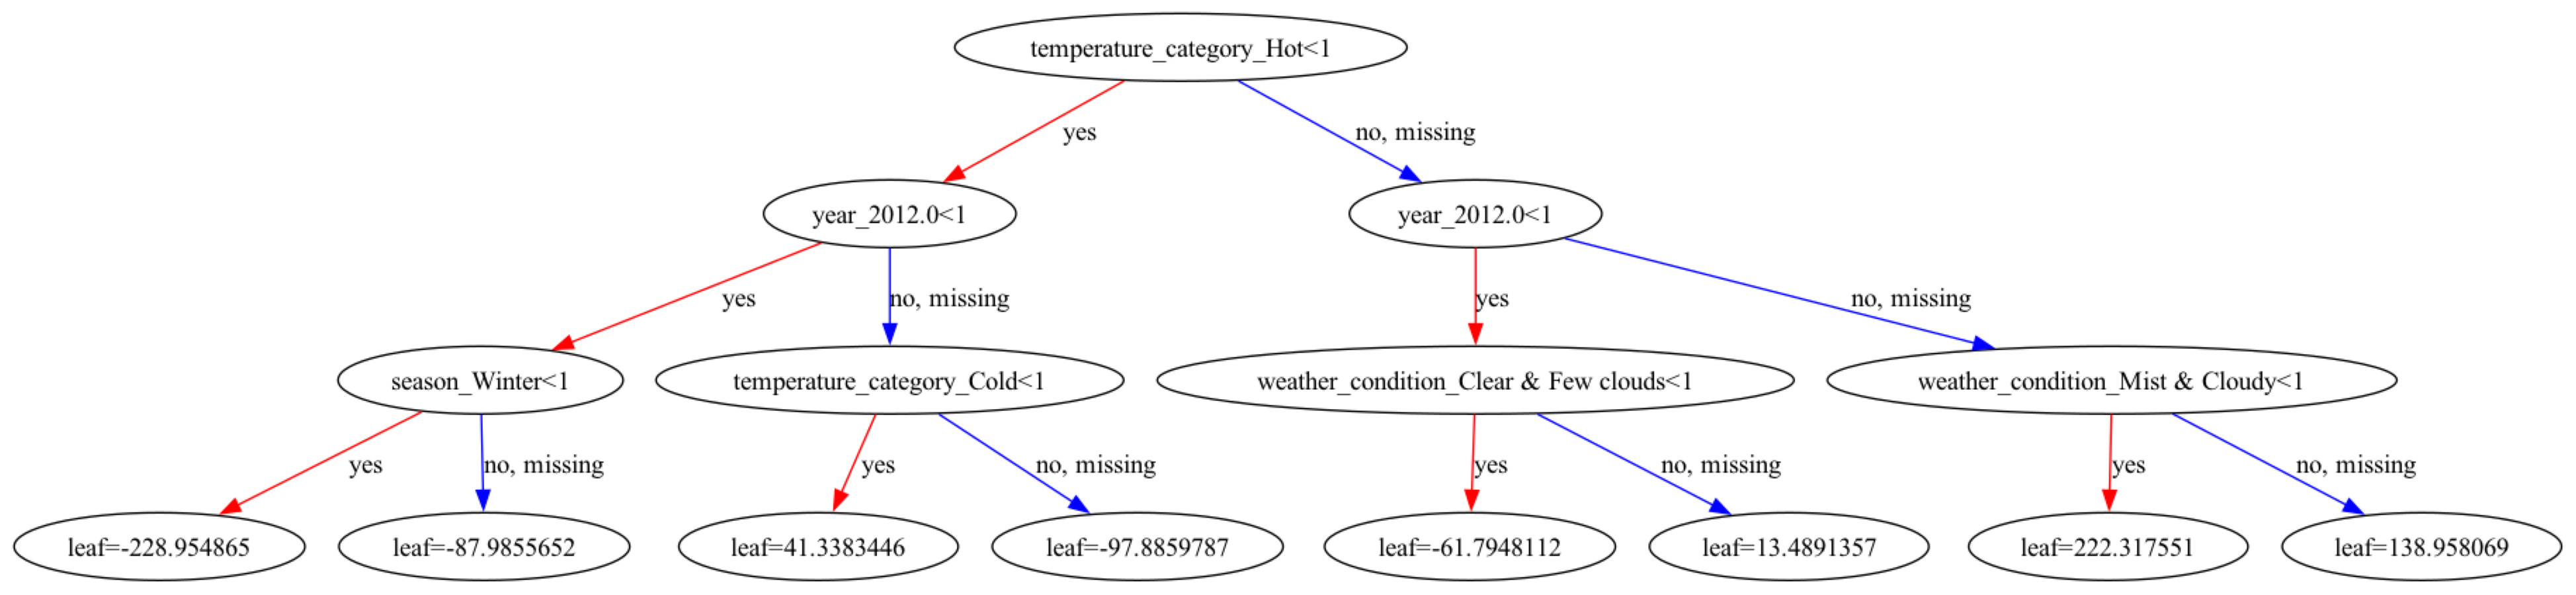

In [70]:
# Visualize the first tree in the booster
xgb.plot_tree(xg_reg, num_trees=1)
plt.gcf().set_size_inches(50, 50)
plt.show()

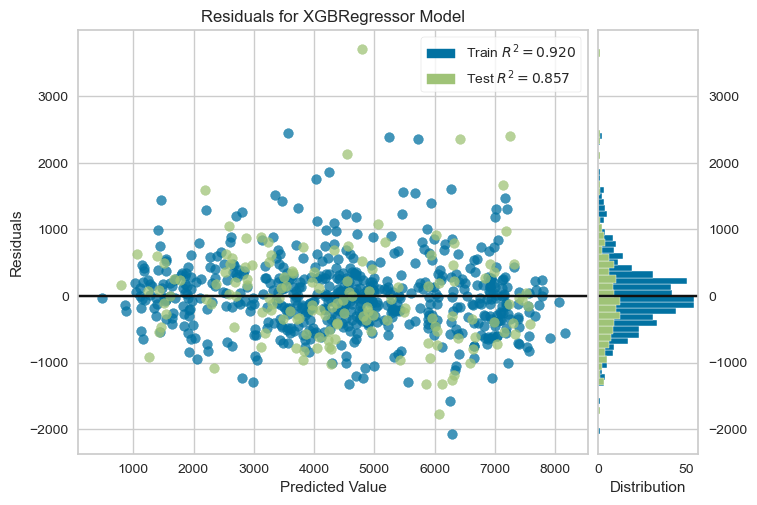

In [71]:
# Visualize residuals 
visualize_residuals(xg_reg, X_train, y_train, X_test, y_test)

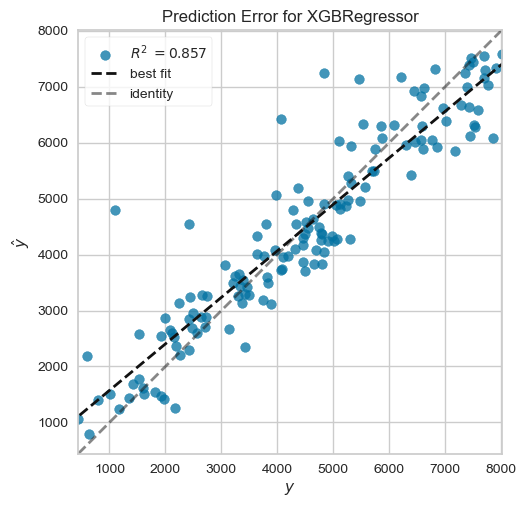

In [72]:
# Prediction error plot
visualize_prediction_error(xg_reg, X_train, y_train, X_test, y_test)

### Gradient Boosting Regressor

#### Hyperparameter Tuning - Optuna

In [73]:
help(GradientBoostingRegressor())

Help on GradientBoostingRegressor in module sklearn.ensemble._gb object:

class GradientBoostingRegressor(sklearn.base.RegressorMixin, BaseGradientBoosting)
 |  GradientBoostingRegressor(*, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
 |  
 |  Gradient Boosting for regression.
 |  
 |  This estimator builds an additive model in a forward stage-wise fashion; it
 |  allows for the optimization of arbitrary differentiable loss functions. In
 |  each stage a regression tree is fit on the negative gradient of the given
 |  loss function.
 |  
 |  :class:`sklearn.ensemble.HistGradientBoostingRegressor` is a much faster
 |  variant of this algorith

In [74]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4)
    }

    # Create a GradientBoostingRegressor with trial parameters
    gb_reg = GradientBoostingRegressor(random_state=random_state, **params)

    # Calculate cross-validated R-squared score using KFold
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_score = cross_val_score(gb_reg, X_train, y_train, cv=cv, scoring='r2')
    score = cv_score.mean()
    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and the best score
best_params_gb = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params_gb)
print("Best R-squared Score:", best_score)

[I 2024-04-01 19:04:51,204] A new study created in memory with name: no-name-157e8b56-a55d-4fda-b35a-88ad4572bf25
[I 2024-04-01 19:04:52,069] Trial 0 finished with value: 0.8426843390941736 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.08824827332531326, 'subsample': 0.7595029024246454, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8426843390941736.
[I 2024-04-01 19:04:52,599] Trial 1 finished with value: 0.2530752730289083 and parameters: {'n_estimators': 59, 'max_depth': 8, 'learning_rate': 0.003355515338761238, 'subsample': 0.7067609013182155, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8426843390941736.
[I 2024-04-01 19:04:53,203] Trial 2 finished with value: 0.5237969547231283 and parameters: {'n_estimators': 97, 'max_depth': 4, 'learning_rate': 0.005724134259170117, 'subsample': 0.8222472696866396, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8426843390941

Best Parameters: {'n_estimators': 87, 'max_depth': 4, 'learning_rate': 0.08056508532345716, 'subsample': 0.8038210362518144, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best R-squared Score: 0.8583229366260017


In [75]:
# Instantiate a GradientBoostingRegressor model with the best hyperparameters
gb_reg = GradientBoostingRegressor(**best_params_gb, random_state=random_state)

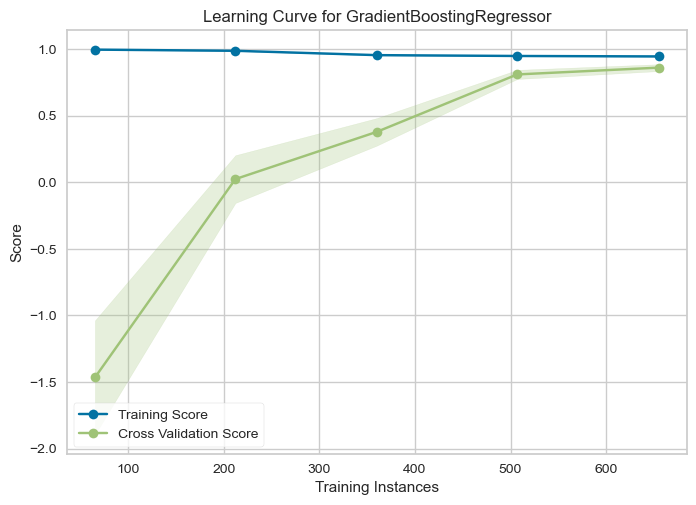

In [76]:
# Plot the learning curve
plot_learning_curve(X, y, gb_reg)

In [77]:
# Fit the model to the training data
gb_reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.08056508532345716, max_depth=4,
                          n_estimators=87, random_state=2024,
                          subsample=0.8038210362518144)

In [78]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in gb_reg.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in gb_reg.feature_importances_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

,Feature,Coefficient,AbsCoefficient
0,season_Spring,0.182629,0.182629
33,temperature_category_Cold,0.181121,0.181121
5,year_2012.0,0.158177,0.158177
4,year_2011.0,0.136953,0.136953
35,temperature_category_Hot,0.068374,0.068374
31,weather_condition_Clear & Few clouds,0.035961,0.035961
32,weather_condition_Light snow & Rain,0.034947,0.034947
18,day,0.027062,0.027062
3,season_Winter,0.026489,0.026489
34,temperature_category_Moderate,0.022067,0.022067


In [79]:
# Evaluate GradientBoostingRegressor and compare train and test results
evaluate_model(gb_reg, X_train, y_train, X_test, y_test)

+--------------------+---------------+--------------+
| Metric             |   Train Score |   Test Score |
+====================+===============+==============+
| Execution Time (s) |        0.0035 |       0.0035 |
+--------------------+---------------+--------------+
| MAE                |      318.7722 |     541.4307 |
+--------------------+---------------+--------------+
| RMSE               |      437.5533 |     740.1425 |
+--------------------+---------------+--------------+
| R^2                |        0.9483 |       0.8567 |
+--------------------+---------------+--------------+
| Adjusted R^2       |        0.9443 |       0.7982 |
+--------------------+---------------+--------------+
| MAPE               |       13.2907 |      19.0604 |
+--------------------+---------------+--------------+
| Max Error          |     2091.5512 |    3754.2472 |
+--------------------+---------------+--------------+


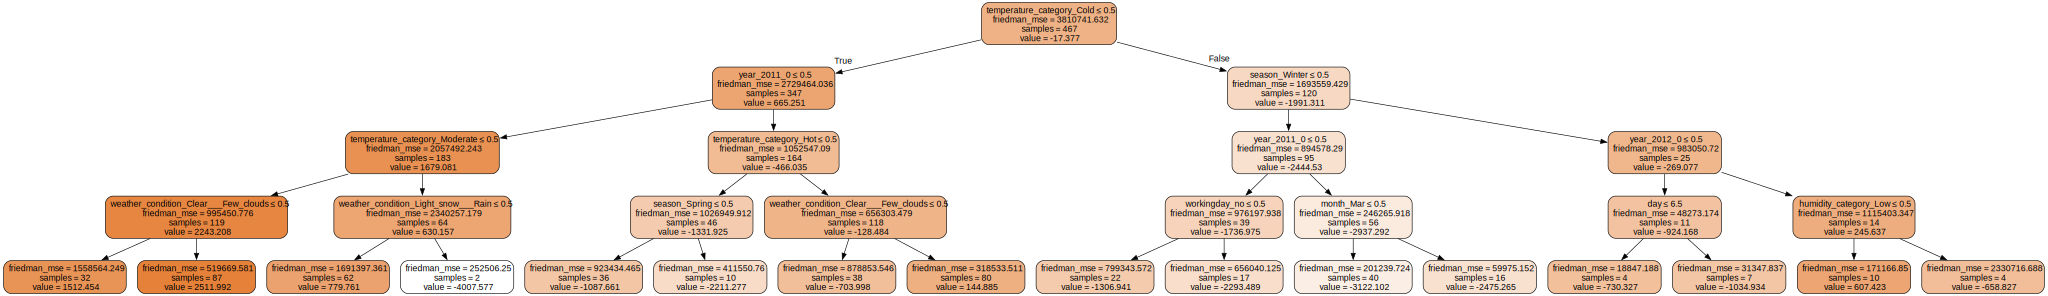

In [80]:
# Accessing one of the decision trees from the gradient boosting regressor
tree_in_gb = gb_reg.estimators_[0][0]  # Accessing the first tree of the first estimator

# Export the decision tree to Graphviz format
dot_data = tree.export_graphviz(tree_in_gb, out_file=None,
                                feature_names=[re.sub('[^a-zA-Z0-9_]', '_', feature) for feature in X_train.columns],
                                filled=True, rounded=True,
                                special_characters=True)

# Visualize the decision tree
graph = graphviz.Source(dot_data)
# graph.render("gradient_boosting_tree")  # Optionally save the tree to a file
# graph.view()  # View the tree in the default viewer
graph

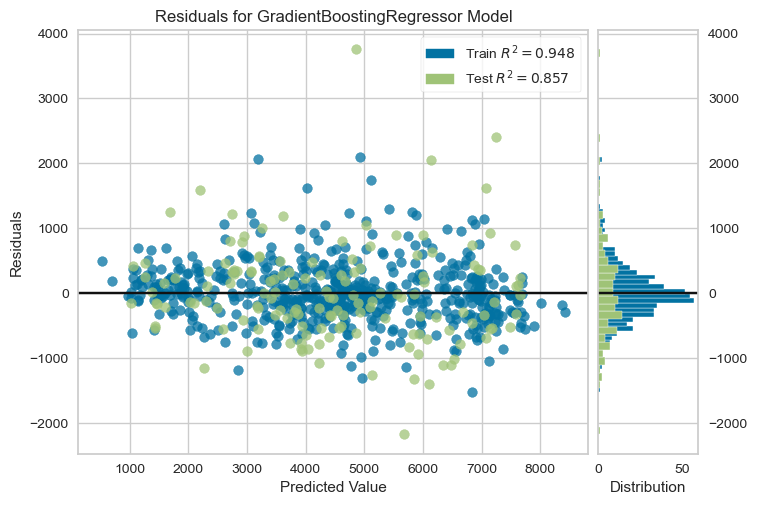

In [81]:
# Visualize residuals
visualize_residuals(gb_reg, X_train, y_train, X_test, y_test)

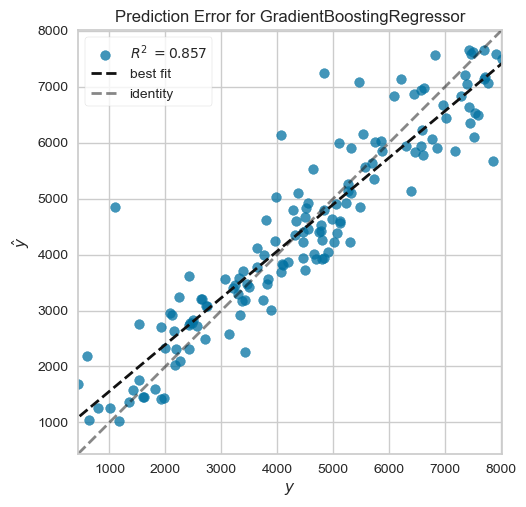

In [82]:
# Prediction error plot
visualize_prediction_error(gb_reg, X_train, y_train, X_test, y_test)

### Lasso Regression

#### Hyperparameter Tuning - Optuna

In [83]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
        'max_iter': trial.suggest_int('max_iter', 1000, 10000)
    }

    # Create a Lasso regressor with trial parameters
    lasso_reg = Lasso(random_state=random_state, **params)

    # Calculate cross-validated R-squared score using KFold
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    cv_score = cross_val_score(lasso_reg, X_train, y_train, cv=cv, scoring='r2')
    return cv_score.mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters and the best score
best_params_lasso = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params_lasso)
print("Best R-squared Score:", best_score)

[I 2024-04-01 19:05:24,662] A new study created in memory with name: no-name-1f7f36ae-662d-4bd9-9963-c343d0e4dea7
[I 2024-04-01 19:05:25,821] Trial 0 finished with value: 0.8258315835871608 and parameters: {'alpha': 0.09090569124586453, 'max_iter': 6868}. Best is trial 0 with value: 0.8258315835871608.
[I 2024-04-01 19:06:12,422] Trial 1 finished with value: 0.8257639649773318 and parameters: {'alpha': 0.015231403378934213, 'max_iter': 8469}. Best is trial 0 with value: 0.8258315835871608.
[I 2024-04-01 19:06:12,624] Trial 2 finished with value: 0.8244169377973007 and parameters: {'alpha': 8.532710235776719, 'max_iter': 4083}. Best is trial 0 with value: 0.8258315835871608.
[I 2024-04-01 19:06:26,555] Trial 3 finished with value: 0.8257462548019292 and parameters: {'alpha': 4.2080307710429853e-05, 'max_iter': 1664}. Best is trial 0 with value: 0.8258315835871608.
[I 2024-04-01 19:07:14,507] Trial 4 finished with value: 0.8257465100966973 and parameters: {'alpha': 0.000339618987790981, 

Best Parameters: {'alpha': 0.6377181197570965, 'max_iter': 6035}
Best R-squared Score: 0.8261080220674859


In [84]:
# Instantiate a Lasso model with the best hyperparameters
lasso_reg = Lasso(**best_params_lasso, random_state=random_state)

### Feature Selection - Recursive Feature Elimination

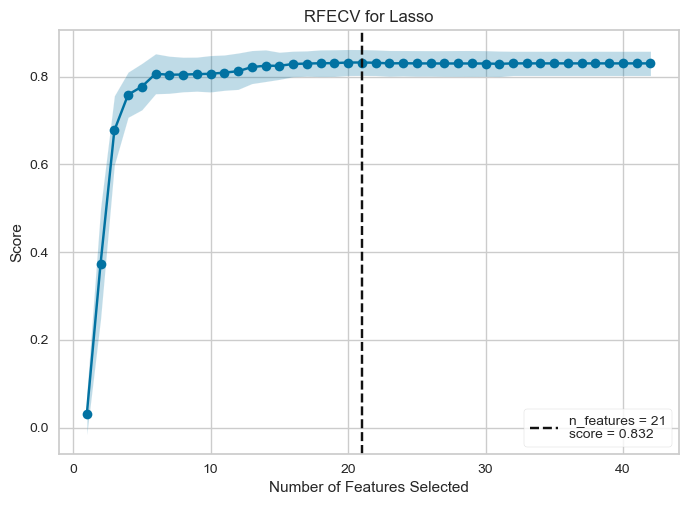

<Axes: title={'center': 'RFECV for Lasso'}, xlabel='Number of Features Selected', ylabel='Score'>

In [85]:
# Recursive Feature Elimination with Cross Validation
vis = RFECV(lasso_reg, cv=cv, scoring='r2')
vis.fit(X_train, y_train)
vis.show()

In [86]:
# Check supported columns
X.columns[vis.support_]

Index(['season_Spring', 'season_Summer', 'season_Winter', 'year_2011.0',
       'month_Jan', 'month_Feb', 'month_Apr', 'month_Jun', 'month_Sep',
       'month_Nov', 'month_Dec', 'holiday_no', 'weekday_Sunday',
       'weekday_Monday', 'weekday_Tuesday',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature_category_Cold',
       'temperature_category_Hot', 'humidity_category_High',
       'wind_speed_category_Low'],
      dtype='object')

In [87]:
# Since the columns are one-hot encoded, standartization process is skipped
# Split the data into train and test only with supported columns by RFECV  
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, vis.support_], y, test_size=0.20, random_state=random_state)

In [88]:
# Make sure train set does not contain target column
X_train.columns

Index(['season_Spring', 'season_Summer', 'season_Winter', 'year_2011.0',
       'month_Jan', 'month_Feb', 'month_Apr', 'month_Jun', 'month_Sep',
       'month_Nov', 'month_Dec', 'holiday_no', 'weekday_Sunday',
       'weekday_Monday', 'weekday_Tuesday',
       'weather_condition_Clear & Few clouds',
       'weather_condition_Light snow & Rain', 'temperature_category_Cold',
       'temperature_category_Hot', 'humidity_category_High',
       'wind_speed_category_Low'],
      dtype='object')

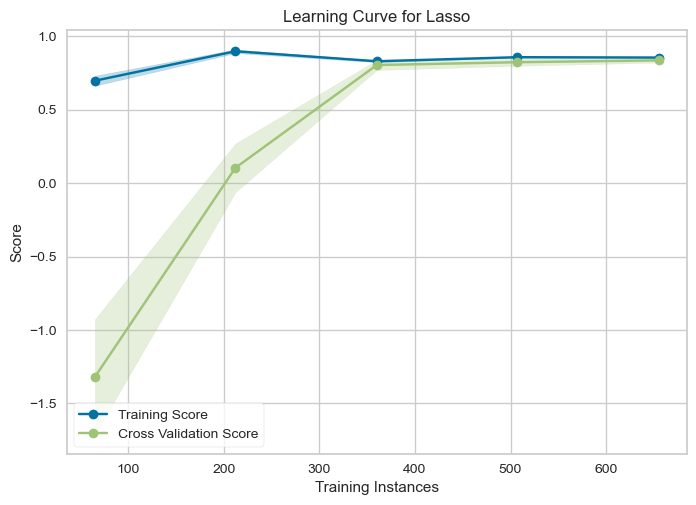

In [89]:
# Plot the learning curve
plot_learning_curve(X, y, lasso_reg)

In [90]:
# Fit the model to the training data
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.6377181197570965, max_iter=6035, random_state=2024)

In [91]:
# Print the Intercept
print('Intercept:',lasso_reg.intercept_, '\n')

# Print Coefficients by descending "importance"
formattedList = [format(float(i),'.6f') for i in lasso_reg.coef_]
formattedList2 = [format(abs(float(i)),'.6f') for i in lasso_reg.coef_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df['AbsCoefficient']=coeff_df['AbsCoefficient'].astype(float)
coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
coeff_df

Intercept: 5219.86144207824 



,Feature,Coefficient,AbsCoefficient
3,season_Winter,-2028.169670,2028.169670
16,month_Nov,-1800.630412,1800.630412
0,season_Spring,-1102.384551,1102.384551
17,month_Dec,-819.427843,819.427843
18,day,794.508744,794.508744
4,year_2011.0,-669.618162,669.618162
15,month_Oct,610.615249,610.615249
9,month_Apr,-567.747198,567.747198
10,month_May,-505.694662,505.694662
12,month_Jul,-496.004532,496.004532


In [92]:
# Evaluate Lasso and compare train and test results
evaluate_model(lasso_reg, X_train, y_train, X_test, y_test)

+--------------------+---------------+--------------+
| Metric             |   Train Score |   Test Score |
+====================+===============+==============+
| Execution Time (s) |        0.0122 |       0.0122 |
+--------------------+---------------+--------------+
| MAE                |      528.9503 |     562.3914 |
+--------------------+---------------+--------------+
| RMSE               |      739.7025 |     756.5938 |
+--------------------+---------------+--------------+
| R^2                |        0.8523 |       0.8502 |
+--------------------+---------------+--------------+
| Adjusted R^2       |        0.8467 |       0.8248 |
+--------------------+---------------+--------------+
| MAPE               |       44.9667 |      18.8199 |
+--------------------+---------------+--------------+
| Max Error          |     3596.1104 |    3646.2080 |
+--------------------+---------------+--------------+


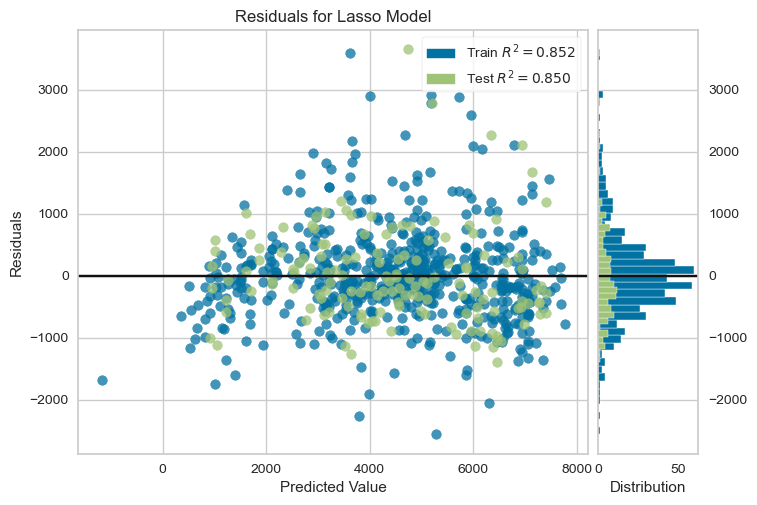

In [93]:
# Visualize residuals 
visualize_residuals(lasso_reg, X_train, y_train, X_test, y_test)

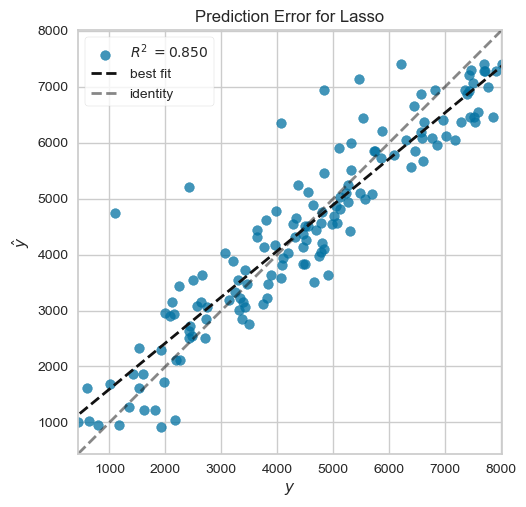

In [94]:
# Prediction error plot
visualize_prediction_error(lasso_reg, X_train, y_train, X_test, y_test)

## EVALUATION

Based on the provided metrics and feature coefficients, it appears that the best-performing model is the one with the following characteristics:

#### **Model**: Lasso Regression
##### **Performance Metrics**
*Test results*:
- **Execution Time (s): 0.0036** 
        <p>*Both the training and testing times are very low (0.0036 seconds), indicating that the model trains and predicts quickly.*
- **MAE (Mean Absolute Error): 562.3914** 
        <p>*The MAE measures the average absolute difference between the predicted and actual values. A lower MAE indicates better performance. The MAE on the test set (562.3914) is slightly higher than on the training set (528.9503), but the difference is not substantial.*
- **RMSE (Root Mean Squared Error): 756.5938**
        <p>*RMSE measures the average squared difference between the predicted and actual values, taking the square root to bring the metric back to the original scale. Again, lower values are better. Like MAE, the RMSE on the test set (756.5938) is slightly higher than on the training set (739.7025).*
- **R^2 (Coefficient of Determination): 0.8502**
        <p>*R-squared represents the proportion of variance in the dependent variable that is predictable from the independent variables. It ranges from 0 to 1, with higher values indicating better fit. Both the training (0.8523) and testing (0.8502) R-squared values indicate that the model explains a good amount of the variance in the data.*
- **Adjusted R^2: 0.8248**
        <p>*Adjusted R-squared is similar to R-squared, but it adjusts for the number of predictors in the model. It penalizes the addition of unnecessary predictors that do not improve the model significantly. The testing adjusted R-squared (0.8248) is lower than the training adjusted R-squared (0.8467), indicating a potential overfitting issue or that some predictors in the model may not be contributing meaningfully to the prediction.*
- **MAPE (Mean Absolute Percentage Error): 18.8199**
        <p>*MAPE measures the percentage difference between the predicted and actual values. Lower values are better. It's important to note that MAPE is sensitive to outliers. In this case, the MAPE on the test set (18.8199%) is substantially lower than on the training set (44.9667%), which could indicate that the model performs better on the test data in terms of relative error.*     
- **Max Error: 3646.2080**
        <p>*Max Error simply represents the maximum difference between predicted and actual values. Lower values are desirable. Both the training and testing max errors are relatively high, indicating that there are instances where the model performs poorly.*

##### **Feature Importance**
*Top 5 Features*:
- Year 2011
- Weather Condition: Light snow & Rain
- Season: Spring
- Temperature Category: Cold
- Temperature Category: Hot

*Significant Features*:
Various months, weekdays, wind speed, humidity, and holiday categories also show notable impacts on the target variable.

##### **Learning Curve**

The Lasso model's performance on both training and cross-validation data can be seen in the learning curve plot. The model performs better on the training set of data at first, but after an unusual start, the cross-validation scores quickly improve.  The two curves eventually converge at a specific point, signifying consistent performance on unseen data.  This convergence shows that the model generalizes well without significant underfitting or overfitting. 

##### **Residuals**
Residuals are random and centered around zero, indicating that the model captures systematic patterns in the data. This suggests that the model is properly fitting the actual data, with the average residual being close to zero, implying unbiased predictions.


##### **Overall Assessment**
The Lasso Regression model demonstrates strong predictive performance with relatively low errors and high R^2 values, indicating a good fit to the data. Train and test set results are pretty close. The feature importance analysis reveals several key factors influencing the target variable, including weather conditions, seasonality, and temperature categories. However, it's essential to note that while some features contribute significantly to the model's predictions, others may have minimal impact or even negative coefficients.

#### Save the best model 

In [95]:
# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(lasso_reg, f)